# Predicting Movie Revenue

## Features  

**Variable to Predict:** Revenue


- Budget  
- Runtime  
- Genre  
- Release Date  
 - Season  
 - Holiday   
- Production Companies  
 - Number of companies involved  
 - Number of movies a company has made (previously)  
- Crew
 - Number of crewmembers  
- Cast
 - Gender Ratio for top 2/5/10/25
 - Number of previous movies top 10 cast have been in
- Collection
 - Is sequel (order)  


In [3]:
import numpy as np
import pandas as pd
import sqlite3
import holidays
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta, date
from scipy import stats

pd.set_option('display.float_format','{:,.2f}'.format)

In [4]:
db = sqlite3.connect(r'../../../Data Science Data/Unit 3/db.sqlite')

In [5]:
## SQL import statements to create dataframes

# Base dataframe to join other onto
base_df = pd.read_sql("""SELECT movie_id, budget, release_date, revenue, runtime, imdb_budget, imdb_revenue, title, collection 
                         FROM movies 
                         WHERE (budget > 0 OR imdb_budget > 0) AND (revenue > 0 OR imdb_revenue > 0)
                      """, db, index_col='movie_id', parse_dates=['release_date'])
base_df.index = base_df.index.map(int)

# Pull in genre table to create dummy variables
genre_df = pd.read_sql("""SELECT * FROM genres""", db)

# Create series for number of production companies associated with each movie_id
number_of_prod_companies = pd.read_sql("""SELECT movie_id, COUNT(company_name) AS prod_company_count
                                          FROM production_companies
                                          GROUP BY movie_id
                                          """, db, index_col='movie_id')
number_of_prod_companies.index = number_of_prod_companies.index.map(int)

production_companies = pd.read_sql("""
    SELECT *
    FROM production_companies
    """, db)
production_companies['movie_id'] = production_companies['movie_id'].map(int)

# Create series for number of crew members associated with each movie_id
number_of_crewmembers = pd.read_sql("""SELECT movie_id, COUNT(crew_member_id) AS crewmember_count
                                       FROM crew
                                       GROUP BY movie_id
                                       """, db, index_col='movie_id')
number_of_crewmembers.index = number_of_crewmembers.index.map(int)

# Dataframe for cast data to create gender ratio, and number of previous movies for cast
cast_data = pd.read_sql("""SELECT cc.movie_id, cc.cast_member_id, cc.cast_order, c.gender, m.release_date
                           FROM cast_credit cc
                           JOIN cast c ON cc.cast_member_id = c.cast_member_id
                           JOIN movies m ON cc.movie_id = m.movie_id
                                  """, db)
cast_data.index = cast_data.index.map(int)

In [6]:
# Create feature to note if the movie is a sequel
base_df.sort_values(['collection', 'release_date'], inplace=True)
base_df['order_in_collection'] = 1

current = None
counter = 1

for index, row in base_df.iterrows():
    if row['collection'] is None:
        break
    if current != row['collection']:
        counter = 1
    base_df.set_value(index,'order_in_collection', counter)
    current = row['collection']
    counter += 1

In [7]:
# Create feature for season
seasons = {
    1:'winter',
    2:'winter',
    3:'spring',
    4:'spring',
    5:'spring',
    6:'summer',
    7:'summer',
    8:'summer',
    9:'fall',
    10:'fall',
    11:'fall',
    12:'winter'
}

def season_for_date(date):
    if pd.notnull(date):
        return seasons[date.month]
    else:
        return None

movie_season = base_df['release_date'].apply(season_for_date)
movie_season.rename('season', inplace=True);

In [8]:
# Create feature for holiday
us_holidays = holidays.UnitedStates()

def check_holiday(date):
    if pd.notnull(date):
        return any((date + timedelta(days=i)) in us_holidays for i in range(-4,5))
    else:
        return None
    
movie_is_holiday = base_df['release_date'].apply(check_holiday)
movie_is_holiday.rename('is_holiday', inplace=True);

In [9]:
# Create feature for production company experience
production_companies_joined = production_companies.merge(base_df, left_on='movie_id', right_index=True, how='left')

production_companies_joined.sort_values(['company_name', 'release_date'], inplace=True)
production_companies_joined['movies_produced'] = 0

current = None
counter = 0

for index, row in production_companies_joined.iterrows():
    if current != row['company_name']:
        counter = 0
    production_companies_joined.set_value(index,'movies_produced', counter)
    current = row['company_name']
    counter += 1
    
production_company_experience = production_companies_joined.groupby(by='movie_id').sum()['movies_produced']

In [10]:
# Create feature for cast experience
cast_data.sort_values(['cast_member_id', 'release_date'], inplace=True)
cast_data['movie_experience'] = 0

current = None
counter = 0

for index, row in cast_data.iterrows():
    if current != row['cast_member_id']:
        counter = 0
    cast_data.set_value(index,'movie_experience', counter)
    current = row['cast_member_id']
    counter += 1
    
cast_experience = cast_data[cast_data['cast_order'] <= 10].groupby('movie_id').sum()['movie_experience']

In [11]:
# Create dummy variables for genre
pivot_genre = genre_df.pivot_table(index='movie_id',columns='genre_name', values='genre_name',aggfunc=len, fill_value=0)
pivot_genre.index = pivot_genre.index.map(int)
pivot_genre = pivot_genre.apply(pd.to_numeric)

In [12]:
# Create column for gender ratio
gender_data = cast_data[cast_data['gender'] != 0]
gender_data = gender_data[gender_data['cast_order'] <= 5]
gender_data['gender'] = gender_data['gender'] - 1
gender_data = gender_data.groupby(by='movie_id').mean()['gender']
gender_data.index = gender_data.index.map(int)

In [13]:
# Join 'em up
df = base_df.join(pivot_genre, how='inner')
df = df.join(number_of_prod_companies, how='inner')
df = df.join(number_of_crewmembers, how='inner')
df = df.join(gender_data, how='inner')
df = df.join(cast_experience, how='inner')
df = df.join(production_company_experience, how='inner')
df = df.join(movie_is_holiday, how='inner')
df = df.join(movie_season, how='inner')

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6195 entries, 117263 to 394117
Data columns (total 36 columns):
budget                 6195 non-null int64
release_date           6195 non-null datetime64[ns]
revenue                6195 non-null int64
runtime                6188 non-null float64
imdb_budget            1938 non-null object
imdb_revenue           2007 non-null object
title                  6195 non-null object
collection             1254 non-null object
order_in_collection    6195 non-null int64
Action                 6195 non-null int64
Adventure              6195 non-null int64
Animation              6195 non-null int64
Comedy                 6195 non-null int64
Crime                  6195 non-null int64
Documentary            6195 non-null int64
Drama                  6195 non-null int64
Family                 6195 non-null int64
Fantasy                6195 non-null int64
Foreign                6195 non-null int64
History                6195 non-null int64
Horror     

In [14]:
df['complete_budget'] = df['budget'].replace(0,np.nan).fillna(df['imdb_budget'])
df['complete_revenue'] = df['revenue'].replace(0,np.nan).fillna(df['imdb_revenue'])

df['complete_budget'] = pd.to_numeric(df['complete_budget'],errors='coerce',downcast='integer')
df['complete_revenue'] = pd.to_numeric(df['complete_revenue'],errors='coerce',downcast='integer')

df['runtime'] = pd.to_numeric(df['runtime'],downcast='integer')
df['gender'] = pd.to_numeric(df['gender'],downcast='integer')

In [15]:
df['is_sequel'] = df['order_in_collection'] > 1
df['profit'] = df['complete_revenue'] - df['complete_budget']
df['ROI'] = df['profit'] / df['complete_budget']
df['gross_margin'] = df['complete_revenue'] / df['complete_budget']
df['log_revenue'] = df['complete_revenue'].apply(np.log)
df['log_budget'] = df['complete_budget'].apply(np.log)

In [16]:
cols_to_drop = ['budget','revenue','imdb_budget','imdb_revenue','collection','order_in_collection']
df.drop(cols_to_drop,axis=1,inplace=True)
df.dropna(inplace=True)
df.drop(df[df['release_date'].dt.year < 1965].index,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5334 entries, 117263 to 394117
Data columns (total 38 columns):
release_date          5334 non-null datetime64[ns]
runtime               5334 non-null float64
title                 5334 non-null object
Action                5334 non-null int64
Adventure             5334 non-null int64
Animation             5334 non-null int64
Comedy                5334 non-null int64
Crime                 5334 non-null int64
Documentary           5334 non-null int64
Drama                 5334 non-null int64
Family                5334 non-null int64
Fantasy               5334 non-null int64
Foreign               5334 non-null int64
History               5334 non-null int64
Horror                5334 non-null int64
Music                 5334 non-null int64
Mystery               5334 non-null int64
Romance               5334 non-null int64
Science Fiction       5334 non-null int64
TV Movie              5334 non-null int64
Thriller              5334 non-nul

In [17]:
# Top 10 box office grossing movies
df.sort_values('complete_revenue',ascending=False,inplace=True)
df.head(n=10)

,release_date,runtime,title,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,...,is_holiday,season,complete_budget,complete_revenue,is_sequel,profit,ROI,gross_margin,log_revenue,log_budget
movie_id,,,,,,,,,,,,,,,,,,,,,
1362,1977-11-27,77.00,The Hobbit,0,1,1,0,0,0,0,...,True,fall,"3,000,000.00","5,000,000,000.00",False,"4,997,000,000.00","1,665.67","1,666.67",22.33,14.91
19995,2009-12-10,162.00,Avatar,1,1,0,0,0,0,0,...,False,winter,"237,000,000.00","2,787,965,087.00",False,"2,550,965,087.00",10.76,11.76,21.75,19.28
140607,2015-12-15,136.00,Star Wars: The Force Awakens,1,1,0,0,0,0,0,...,False,winter,"245,000,000.00","2,068,223,624.00",True,"1,823,223,624.00",7.44,8.44,21.45,19.32
597,1997-11-18,194.00,Titanic,0,0,0,0,0,0,1,...,False,fall,"200,000,000.00","1,845,034,188.00",False,"1,645,034,188.00",8.23,9.23,21.34,19.11
24428,2012-04-25,143.00,The Avengers,1,1,0,0,0,0,0,...,False,spring,"220,000,000.00","1,519,557,910.00",False,"1,299,557,910.00",5.91,6.91,21.14,19.21
135397,2015-06-09,124.00,Jurassic World,1,1,0,0,0,0,0,...,False,summer,"150,000,000.00","1,513,528,810.00",True,"1,363,528,810.00",9.09,10.09,21.14,18.83
168259,2015-04-01,137.00,Furious 7,1,0,0,0,0,0,0,...,False,spring,"190,000,000.00","1,506,249,360.00",True,"1,316,249,360.00",6.93,7.93,21.13,19.06
99861,2015-04-22,141.00,Avengers: Age of Ultron,1,1,0,0,0,0,0,...,False,spring,"280,000,000.00","1,405,403,694.00",True,"1,125,403,694.00",4.02,5.02,21.06,19.45
12445,2011-07-07,130.00,Harry Potter and the Deathly Hallows: Part 2,0,1,0,0,0,0,0,...,True,summer,"125,000,000.00","1,342,000,000.00",True,"1,217,000,000.00",9.74,10.74,21.02,18.64


In [18]:
# The Hobbit animated movie?? Really? Let's remove... 
df.drop(df[df['title'] == 'The Hobbit'].index, inplace=True)

In [19]:
# Look at the lowest quantile to check for outliers
df[df['complete_revenue'] < df['complete_revenue'].quantile(q=.0075)]

# Notes
# Trojan War: Only released in one theater in the US over one weekend. Not a good representation of what we are trying to predict
# Sunrise: Foreign movie released in theaters in the US 2 years after originally released in France
# Skin Trade: Terrible movie that starred Dolph Lungren. With the exception of Rocky, his movies have been terrible. Something to model in the future?
# Next Time I'll Aim for the Heart: French movie. Grossed 4mil Euros, but did very little in the USA. 

,release_date,runtime,title,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,...,is_holiday,season,complete_budget,complete_revenue,is_sequel,profit,ROI,gross_margin,log_revenue,log_budget
movie_id,,,,,,,,,,,,,,,,,,,,,
327833,2014-11-07,96.00,Skin Trade,1,0,0,0,0,0,1,...,True,fall,"9,000,000.00","1,242.00",False,"-8,998,758.00",-1.00,0.00,7.12,16.01
328930,2014-10-03,85.00,Sunrise,0,0,0,0,0,0,1,...,False,fall,"700,000.00","1,000.00",False,"-699,000.00",-1.00,0.00,6.91,13.46
298459,2014-11-12,111.00,Next Time I'll Aim for the Heart,0,0,0,0,1,0,1,...,True,fall,"5,100,000.00",714.00,False,"-5,099,286.00",-1.00,0.00,6.57,15.44
77633,2001-12-21,100.00,Big Shot's Funeral,0,0,0,1,0,0,0,...,True,winter,"3,300,000.00",646.00,False,"-3,299,354.00",-1.00,0.00,6.47,15.01
92493,2011-09-10,105.00,Edwin Boyd: Citizen Gangster,0,0,0,0,1,0,1,...,False,fall,"5,000,000.00",625.00,False,"-4,999,375.00",-1.00,0.00,6.44,15.42
14330,1997-09-26,85.00,Trojan War,0,0,0,1,0,0,0,...,False,fall,"15,000,000.00",217.00,False,"-14,999,783.00",-1.00,0.00,5.38,16.52
57186,2010-10-06,97.00,Skinning,1,0,0,0,1,0,1,...,False,fall,"500,000.00",198.00,False,"-499,802.00",-1.00,0.00,5.29,13.12
22717,2009-09-18,129.00,Wanted,1,0,0,1,1,0,0,...,False,fall,75.00,134.00,False,59.00,0.79,1.79,4.90,4.32
212769,2013-08-07,110.00,Make Your Move,0,0,0,0,0,0,0,...,False,summer,15.00,122.00,False,107.00,7.13,8.13,4.80,2.71


In [20]:
# Remove movies with a budget less than 100,000
df.drop(df[df['complete_budget'] < 100000].index,inplace=True)

upper_quantile_rev = df['complete_revenue'].quantile(q=.9)
bottom_quantile_rev = df['complete_revenue'].quantile(q=.1)
df.drop(df[df['complete_revenue'] < bottom_quantile_rev].index,inplace=True)
df.drop(df[df['complete_revenue'] > upper_quantile_rev].index,inplace=True)

df.describe()

,runtime,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,...,gender,movie_experience,movies_produced,complete_budget,complete_revenue,profit,ROI,gross_margin,log_revenue,log_budget
count,"4,202.00","4,202.00","4,202.00","4,202.00","4,202.00","4,202.00","4,202.00","4,202.00","4,202.00","4,202.00",...,"4,202.00","4,202.00","4,202.00","4,202.00","4,202.00","4,202.00","4,202.00","4,202.00","4,202.00","4,202.00"
mean,110.23,0.26,0.16,0.04,0.38,0.17,0.00,0.49,0.09,0.09,...,0.68,119.54,239.34,"24,578,545.01","44,663,673.34","20,085,128.33",2.83,3.83,16.81,16.42
std,23.25,0.44,0.36,0.19,0.49,0.38,0.07,0.50,0.28,0.28,...,0.23,108.81,284.73,"25,258,574.26","50,203,064.34","42,478,970.04",15.89,15.89,1.47,1.28
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,"100,000.00","480,314.00","-165,710,090.00",-0.99,0.01,13.08,11.51
25%,96.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.50,55.00,20.00,"6,706,750.00","7,994,779.25","-4,526,847.00",-0.32,0.68,15.89,15.72
50%,106.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.67,97.00,92.00,"16,500,000.00","23,801,214.00","6,166,873.50",0.60,1.60,16.99,16.62
75%,120.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,...,0.83,151.00,426.00,"35,000,000.00","64,156,870.25","34,619,500.25",2.33,3.33,17.98,17.37
max,422.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,"1,295.00","1,791.00","255,000,000.00","213,954,274.00","207,954,274.00",652.85,653.85,19.18,19.36


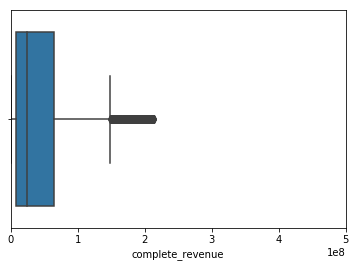

In [21]:
sns.boxplot(x=df['complete_revenue'])
plt.xlim(0,500000000)
plt.show()

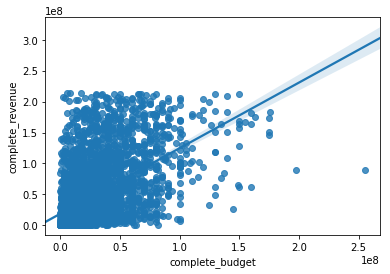

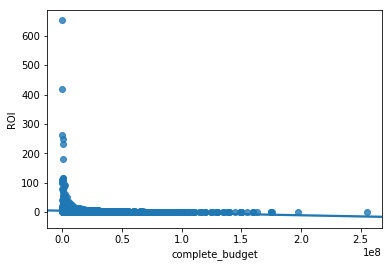

In [22]:
sns.regplot(y=df['complete_revenue'],x=df['complete_budget'])
plt.show() 

sns.regplot(y=df['ROI'],x=df['complete_budget'])
plt.show()

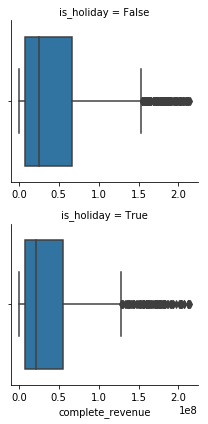

KruskalResult(statistic=3.9260132567033201, pvalue=0.047544530878936411)

In [23]:
g = sns.FacetGrid(df[['is_holiday','complete_revenue','complete_budget']],row='is_holiday')
g.map(sns.boxplot, 'complete_revenue')
plt.show()

stats.kruskal(df[df['is_holiday'] == True]['complete_revenue'], df[df['is_holiday'] == False]['complete_revenue'])

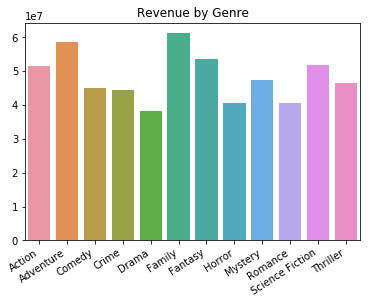

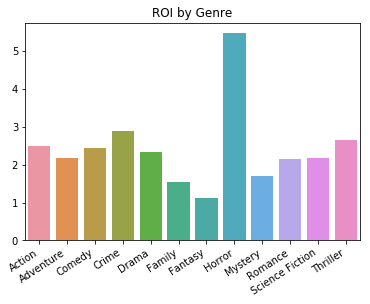

In [24]:
genres = list(genre_df.groupby('genre_name').count().index)

genre_count = {}

for genre in genres:
    genre_count[genre] = df[df[genre] == 1]['complete_revenue'].count()

genre_list = [key for key,values in genre_count.items() if values > 200]

genre_mean = {}
genre_ROI = {}

for genre in genre_list:
    genre_mean[genre] = df[df[genre] == 1]['complete_revenue'].mean()
    genre_ROI[genre] = df[df[genre] == 1]['ROI'].mean()
    
sns.barplot(x=list(genre_mean.keys()),y=[value for value in genre_mean.values()])
plt.title('Revenue by Genre')
plt.xticks(rotation=33, horizontalalignment='right')
plt.show()

sns.barplot(x=list(genre_mean.keys()),y=[value for value in genre_ROI.values()])
plt.title('ROI by Genre')
plt.xticks(rotation=33, horizontalalignment='right')
plt.show()

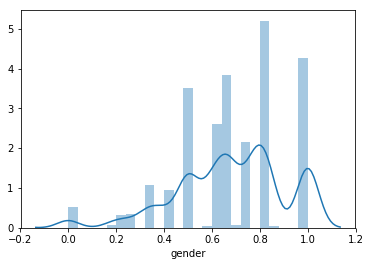

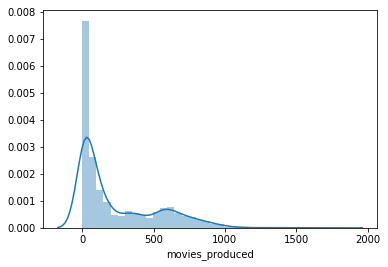

In [25]:
sns.distplot(df['gender'])
plt.show()

sns.distplot(df['movies_produced'])
plt.show()

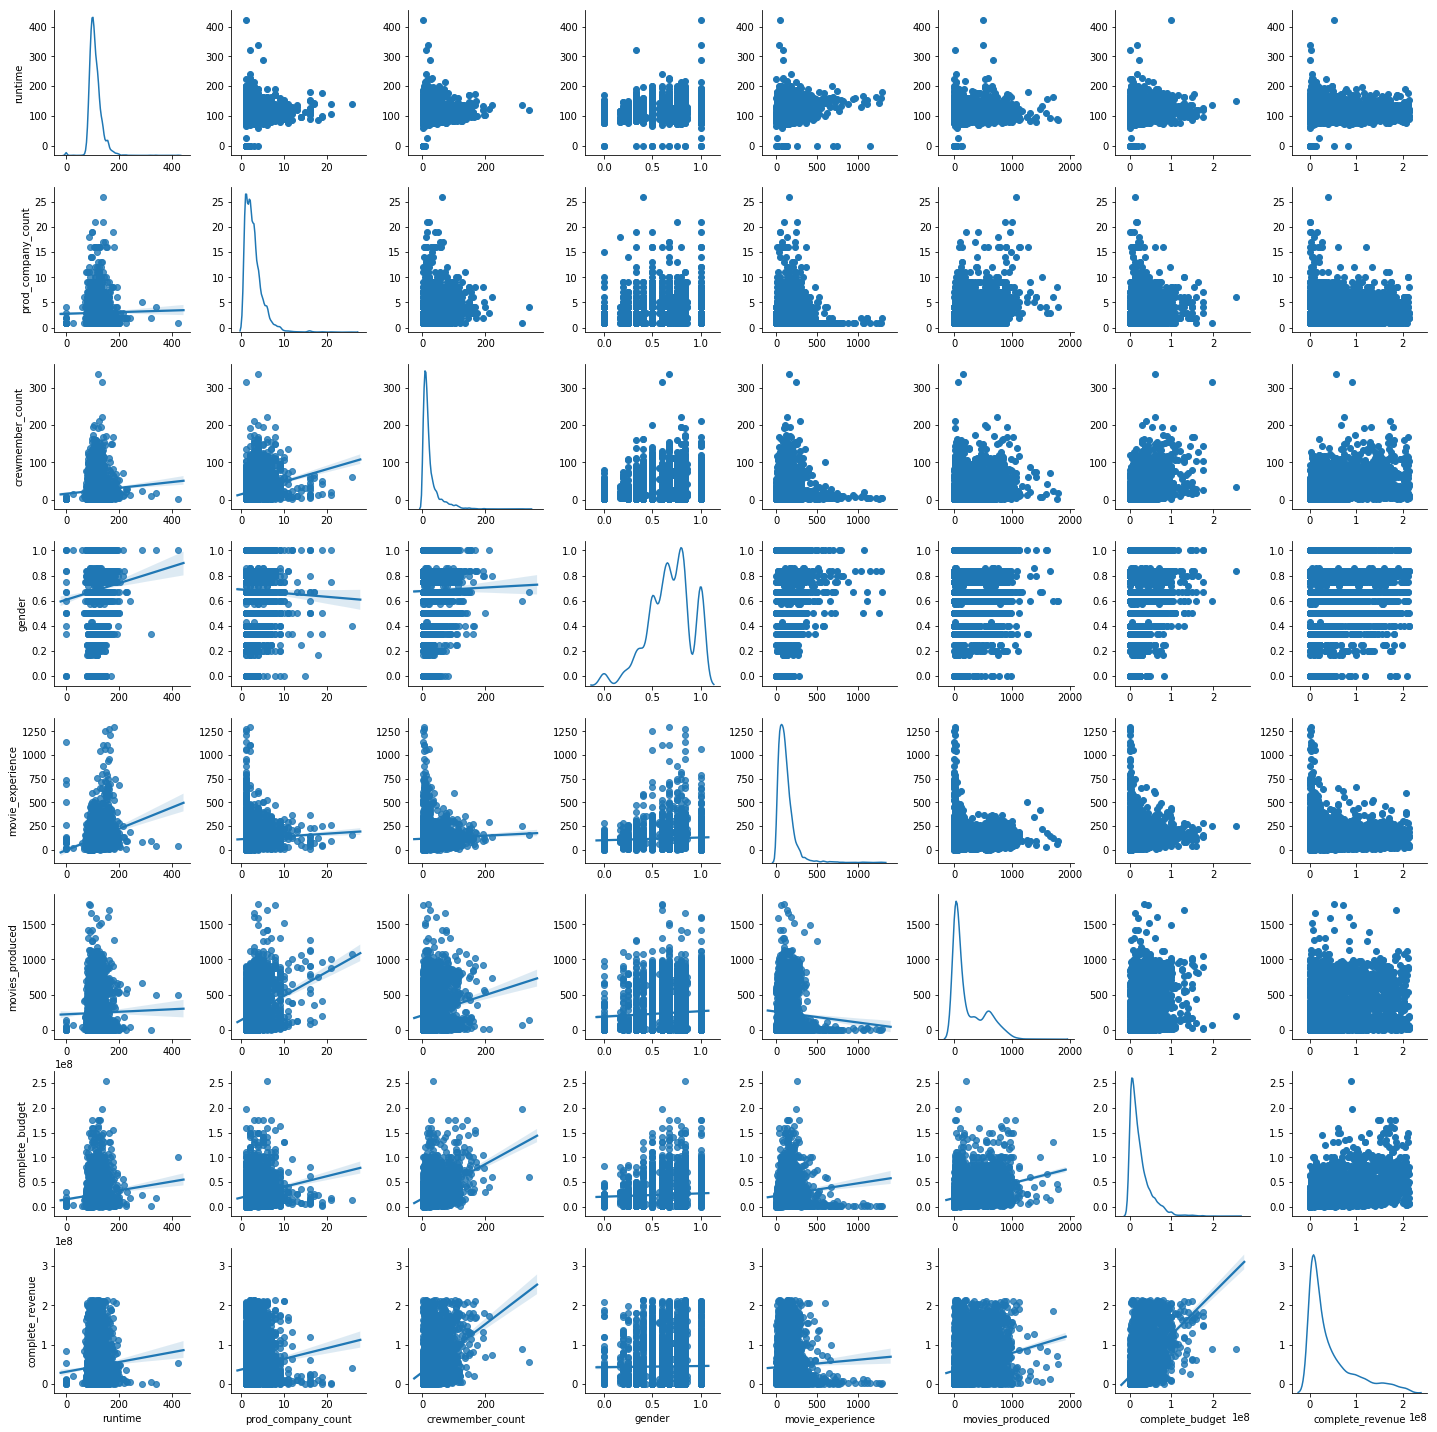

In [26]:
cols = ['runtime','prod_company_count','crewmember_count','gender','movie_experience','movies_produced','complete_budget','complete_revenue']

g = sns.PairGrid(df[cols], diag_sharey=False)
g.map_upper(plt.scatter)
g.map_lower(sns.regplot)
g.map_diag(sns.kdeplot)

plt.show()

In [27]:
df.corr()[['complete_revenue','complete_budget','ROI','gross_margin']]

,complete_revenue,complete_budget,ROI,gross_margin
runtime,0.06,0.08,-0.04,-0.04
Action,0.08,0.18,-0.01,-0.01
Adventure,0.12,0.21,-0.02,-0.02
Animation,0.07,0.11,-0.01,-0.01
Comedy,0.01,-0.04,-0.02,-0.02
Crime,-0.00,-0.00,0.00,0.00
Documentary,-0.00,-0.05,0.05,0.05
Drama,-0.12,-0.11,-0.03,-0.03
Family,0.10,0.14,-0.03,-0.03
Fantasy,0.06,0.16,-0.03,-0.03


In [28]:
drop_genres = set(genres) - set(genre_list)

model_data = df.drop(list(drop_genres),axis=1)
model_data = model_data.drop(['profit','ROI','release_date','title','complete_revenue'],axis=1)
no_budget_model_data = model_data.drop('complete_budget',axis=1)

In [29]:
model_data = model_data.drop(['gross_margin'],axis=1)

In [30]:
df_dum = pd.get_dummies(model_data)

x = df_dum.loc[:,df_dum.columns != 'log_revenue']
y = df_dum['log_revenue']

x_train = x.sample(frac=.8, random_state=30)
y_train = y[x_train.index]

x_test = x.drop(x_train.index)
y_test = y.drop(y_train.index)

x.columns

Index(['runtime', 'Action', 'Adventure', 'Comedy', 'Crime', 'Drama', 'Family',
       'Fantasy', 'Horror', 'Mystery', 'Romance', 'Science Fiction',
       'Thriller', 'prod_company_count', 'crewmember_count', 'gender',
       'movie_experience', 'movies_produced', 'complete_budget', 'is_sequel',
       'log_budget', 'is_holiday_False', 'is_holiday_True', 'season_fall',
       'season_spring', 'season_summer', 'season_winter'],
      dtype='object')

In [31]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import median_absolute_error


dt = DecisionTreeRegressor(max_depth=10,max_features=None)

dt.fit(x_train,y_train)
y_predict = dt.predict(x_test)
dt.score(x_train,y_train)

0.65439983809478908

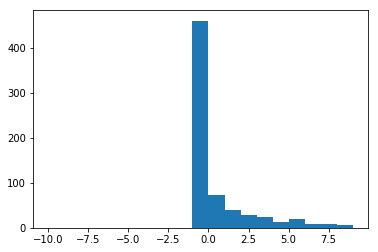

0.030952380952380953

In [32]:
percent_error = (10**y_predict - 10**y_test) / 10**y_test
plt.hist(percent_error, bins=np.arange(-10,10,1))
plt.show()

np.mean((percent_error < .1) & (percent_error > -.1))

In [33]:
x_test['y_actual'] = y_test
x_test['y_predict'] = y_predict
x_test['y_delta'] = (y_predict - y_test) / y_test
x_test.sort_values('y_delta', ascending=True)

,runtime,Action,Adventure,Comedy,Crime,Drama,Family,Fantasy,Horror,Mystery,...,log_budget,is_holiday_False,is_holiday_True,season_fall,season_spring,season_summer,season_winter,y_actual,y_predict,y_delta
movie_id,,,,,,,,,,,,,,,,,,,,,
10228,75.00,0,0,0,0,0,0,0,0,0,...,17.22,1,0,0,0,1,0,18.91,13.11,-0.31
12220,95.00,0,0,1,0,1,0,0,0,0,...,17.73,0,1,1,0,0,0,17.89,13.36,-0.25
550,139.00,0,0,0,0,1,0,0,0,0,...,17.96,0,1,1,0,0,0,18.43,13.87,-0.25
268238,122.00,0,0,1,0,1,0,0,0,0,...,16.12,1,0,0,0,0,1,18.27,13.94,-0.24
170,113.00,0,0,0,0,0,0,0,1,0,...,15.42,1,0,1,0,0,0,18.23,14.05,-0.23
10724,136.00,1,1,0,0,0,0,0,0,0,...,16.71,1,0,0,0,1,0,18.07,14.22,-0.21
146,120.00,1,1,0,0,1,0,0,0,0,...,16.65,1,0,1,0,0,0,19.18,15.09,-0.21
7979,128.00,0,0,0,0,1,0,0,0,0,...,16.81,1,0,1,0,0,0,18.11,14.37,-0.21
10523,131.00,0,0,0,0,1,0,0,0,0,...,17.04,0,1,1,0,0,0,17.20,13.68,-0.20


In [34]:
df_dum = pd.get_dummies(model_data)

x = df_dum.loc[:,df_dum.columns != 'log_revenue']
y = df_dum['log_revenue']

x_train = x.sample(frac=.8, random_state=30)
y_train = y[x_train.index]

x_test = x.drop(x_train.index)
y_test = y.drop(y_train.index)

x.columns

Index(['runtime', 'Action', 'Adventure', 'Comedy', 'Crime', 'Drama', 'Family',
       'Fantasy', 'Horror', 'Mystery', 'Romance', 'Science Fiction',
       'Thriller', 'prod_company_count', 'crewmember_count', 'gender',
       'movie_experience', 'movies_produced', 'complete_budget', 'is_sequel',
       'log_budget', 'is_holiday_False', 'is_holiday_True', 'season_fall',
       'season_spring', 'season_summer', 'season_winter'],
      dtype='object')

In [35]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()

lr.fit(x_train,y_train)
y_predict = lr.predict(x_test)

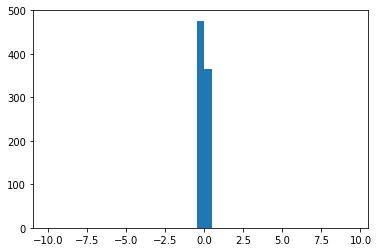

0.85833333333333328

In [36]:
percent_error = (y_predict - y_test) / y_test

plt.hist(percent_error, bins=np.arange(-10,10,.5))
plt.show()
np.mean((percent_error < .1) & (percent_error > -.1))

In [37]:
x_test['y_actual'] = y_test
x_test['y_predict'] = y_predict
x_test['y_delta'] = (y_predict - y_test) / y_test

In [38]:
x_test.sort_values('y_delta', ascending=True)

,runtime,Action,Adventure,Comedy,Crime,Drama,Family,Fantasy,Horror,Mystery,...,log_budget,is_holiday_False,is_holiday_True,season_fall,season_spring,season_summer,season_winter,y_actual,y_predict,y_delta
movie_id,,,,,,,,,,,,,,,,,,,,,
9659,93.00,1,1,0,0,0,0,0,0,0,...,12.90,1,0,0,1,0,0,18.42,14.52,-0.21
10331,96.00,0,0,0,0,0,0,0,1,0,...,11.64,1,0,1,0,0,0,17.22,14.24,-0.17
9062,99.00,0,0,0,0,1,0,0,0,0,...,14.60,1,0,0,0,0,1,18.73,15.77,-0.16
146,120.00,1,1,0,0,1,0,0,0,0,...,16.65,1,0,1,0,0,0,19.18,16.19,-0.16
37247,106.00,0,0,0,0,1,0,0,0,0,...,14.91,0,1,0,0,0,1,18.47,15.73,-0.15
713,121.00,0,0,0,0,1,0,0,0,0,...,15.76,1,0,0,1,0,0,18.58,16.00,-0.14
10246,94.00,0,0,1,0,0,0,0,0,0,...,15.20,0,1,1,0,0,0,18.65,16.10,-0.14
680,154.00,0,0,0,1,0,0,0,0,0,...,15.89,0,1,1,0,0,0,19.18,16.61,-0.13
27977,75.00,0,0,1,0,0,0,0,0,0,...,12.21,1,0,0,0,1,0,16.83,14.61,-0.13


In [39]:
df_dum = pd.get_dummies(model_data)

x = df_dum.loc[:,df_dum.columns != 'log_revenue']
y = df_dum['log_revenue']

x_train = x.sample(frac=.8, random_state=30)
y_train = y[x_train.index]

x_test = x.drop(x_train.index)
y_test = y.drop(y_train.index)

x.columns

Index(['runtime', 'Action', 'Adventure', 'Comedy', 'Crime', 'Drama', 'Family',
       'Fantasy', 'Horror', 'Mystery', 'Romance', 'Science Fiction',
       'Thriller', 'prod_company_count', 'crewmember_count', 'gender',
       'movie_experience', 'movies_produced', 'complete_budget', 'is_sequel',
       'log_budget', 'is_holiday_False', 'is_holiday_True', 'season_fall',
       'season_spring', 'season_summer', 'season_winter'],
      dtype='object')

In [40]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(max_depth=12,max_features=None)

rf.fit(x_train,y_train)
y_predict = dt.predict(x_test)
rf.score(x_train,y_train)

0.78146440561562325

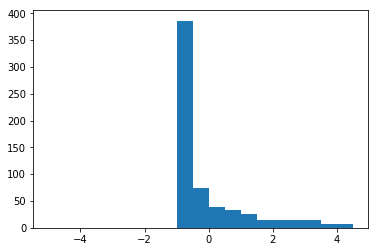

0.030952380952380953

In [41]:
percent_error = (10**y_predict - 10**y_test) / 10**y_test

plt.hist(percent_error, bins=np.arange(-5,5,.5))
plt.show()
np.mean((percent_error < .1) & (percent_error > -.1))

In [42]:
x_test['y_actual'] = y_test
x_test['y_predict'] = y_predict
x_test['y_delta'] = (y_predict - y_test) / y_test
x_test.sort_values('y_delta', ascending=True)

,runtime,Action,Adventure,Comedy,Crime,Drama,Family,Fantasy,Horror,Mystery,...,log_budget,is_holiday_False,is_holiday_True,season_fall,season_spring,season_summer,season_winter,y_actual,y_predict,y_delta
movie_id,,,,,,,,,,,,,,,,,,,,,
10228,75.00,0,0,0,0,0,0,0,0,0,...,17.22,1,0,0,0,1,0,18.91,13.11,-0.31
12220,95.00,0,0,1,0,1,0,0,0,0,...,17.73,0,1,1,0,0,0,17.89,13.36,-0.25
550,139.00,0,0,0,0,1,0,0,0,0,...,17.96,0,1,1,0,0,0,18.43,13.87,-0.25
268238,122.00,0,0,1,0,1,0,0,0,0,...,16.12,1,0,0,0,0,1,18.27,13.94,-0.24
170,113.00,0,0,0,0,0,0,0,1,0,...,15.42,1,0,1,0,0,0,18.23,14.05,-0.23
10724,136.00,1,1,0,0,0,0,0,0,0,...,16.71,1,0,0,0,1,0,18.07,14.22,-0.21
146,120.00,1,1,0,0,1,0,0,0,0,...,16.65,1,0,1,0,0,0,19.18,15.09,-0.21
7979,128.00,0,0,0,0,1,0,0,0,0,...,16.81,1,0,1,0,0,0,18.11,14.37,-0.21
10523,131.00,0,0,0,0,1,0,0,0,0,...,17.04,0,1,1,0,0,0,17.20,13.68,-0.20


In [43]:
df_dum = pd.get_dummies(model_data)

x = df_dum.loc[:,df_dum.columns != 'log_revenue']
y = df_dum['log_revenue']

x_train = x.sample(frac=.8, random_state=30)
y_train = y[x_train.index]

x_test = x.drop(x_train.index)
y_test = y.drop(y_train.index)

x.columns

Index(['runtime', 'Action', 'Adventure', 'Comedy', 'Crime', 'Drama', 'Family',
       'Fantasy', 'Horror', 'Mystery', 'Romance', 'Science Fiction',
       'Thriller', 'prod_company_count', 'crewmember_count', 'gender',
       'movie_experience', 'movies_produced', 'complete_budget', 'is_sequel',
       'log_budget', 'is_holiday_False', 'is_holiday_True', 'season_fall',
       'season_spring', 'season_summer', 'season_winter'],
      dtype='object')

In [44]:
from sklearn.svm import SVR

svr = SVR(C=.5)

svr.fit(x_train,y_train)
y_predict = svr.predict(x_test)
svr.score(x_train,y_train)

0.43205014723797008

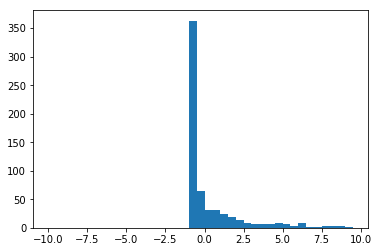

0.021428571428571429

In [45]:
percent_error = (10**y_predict - 10**y_test) / 10**y_test

plt.hist(percent_error, bins=np.arange(-10,10,.5))
plt.show()
np.mean((percent_error < .1) & (percent_error > -.1))

In [57]:
df_dum = pd.get_dummies(model_data)

x = df_dum.loc[:,df_dum.columns != 'log_revenue']
y = df_dum['log_revenue']

x_train = x.sample(frac=.8, random_state=30)
y_train = y[x_train.index]

x_test = x.drop(x_train.index)
y_test = y.drop(y_train.index)

x.columns

Index(['runtime', 'Action', 'Adventure', 'Comedy', 'Crime', 'Drama', 'Family',
       'Fantasy', 'Horror', 'Mystery', 'Romance', 'Science Fiction',
       'Thriller', 'prod_company_count', 'crewmember_count', 'gender',
       'movie_experience', 'movies_produced', 'complete_budget', 'is_sequel',
       'log_budget', 'is_holiday_False', 'is_holiday_True', 'season_fall',
       'season_spring', 'season_summer', 'season_winter'],
      dtype='object')

In [58]:
from tpot import TPOTRegressor
    
tpot = TPOTRegressor(verbosity=3,warm_start=True)

tpot.fit(x_train,y_train)
y_predict = tpot.predict(x_test)
tpot.score(x_train,y_train)

28 operators have been imported by TPOT.


C:\Users\206547663\AppData\Local\Continuum\anaconda3\lib\site-packages\deap\creator.py:141: RuntimeWarning: A class named 'FitnessMulti' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
C:\Users\206547663\AppData\Local\Continuum\anaconda3\lib\site-packages\deap\creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


_pre_test decorator: _random_mutation_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 77


_pre_test decorator: _random_mutation_operator: num_test=1 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l2' and loss='epsilon_insensitive' are not supported when dual=False, Parameters: penalty='l2', loss='epsilon_insensitive', dual=False


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l2' and loss='epsilon_insensitive' are not supported when dual=False, Parameters: penalty='l2', loss='epsilon_insensitive', dual=False


_pre_test decorator: _random_mutation_operator: num_test=0 __init__() got an unexpected keyword argument 'max_depth'


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l2' and loss='epsilon_insensitive' are not supported when dual=False, Parameters: penalty='l2', loss='epsilon_insensitive', dual=False


Generation 1 - Current Pareto front scores:


1	1.306687484819226	RandomForestRegressor(input_matrix, RandomForestRegressor__bootstrap=True, RandomForestRegressor__max_features=0.25, RandomForestRegressor__min_samples_leaf=7, RandomForestRegressor__min_samples_split=11, RandomForestRegressor__n_estimators=100)


_pre_test decorator: _random_mutation_operator: num_test=0 __init__() got an unexpected keyword argument 'max_depth'


_pre_test decorator: _random_mutation_operator: num_test=1 manhattan was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=0 __init__() got an unexpected keyword argument 'max_depth'


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l2' and loss='epsilon_insensitive' are not supported when dual=False, Parameters: penalty='l2', loss='epsilon_insensitive', dual=False


_pre_test decorator: _random_mutation_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 73


_pre_test decorator: _random_mutation_operator: num_test=0 __init__() got an unexpected keyword argument 'max_depth'


_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


Generation 2 - Current Pareto front scores:


1	1.305080702583337	RandomForestRegressor(input_matrix, RandomForestRegressor__bootstrap=True, RandomForestRegressor__max_features=0.25, RandomForestRegressor__min_samples_leaf=1, RandomForestRegressor__min_samples_split=11, RandomForestRegressor__n_estimators=100)


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l2' and loss='epsilon_insensitive' are not supported when dual=False, Parameters: penalty='l2', loss='epsilon_insensitive', dual=False


_pre_test decorator: _random_mutation_operator: num_test=0 __init__() got an unexpected keyword argument 'max_depth'


_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 84


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l2' and loss='epsilon_insensitive' are not supported when dual=False, Parameters: penalty='l2', loss='epsilon_insensitive', dual=False


_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Generation 3 - Current Pareto front scores:


1	1.305080702583337	RandomForestRegressor(input_matrix, RandomForestRegressor__bootstrap=True, RandomForestRegressor__max_features=0.25, RandomForestRegressor__min_samples_leaf=1, RandomForestRegressor__min_samples_split=11, RandomForestRegressor__n_estimators=100)


2	1.3014455051696074	RandomForestRegressor(LassoLarsCV(input_matrix, LassoLarsCV__normalize=True), RandomForestRegressor__bootstrap=True, RandomForestRegressor__max_features=0.4, RandomForestRegressor__min_samples_leaf=12, RandomForestRegressor__min_samples_split=3, RandomForestRegressor__n_estimators=100)


_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=0 manhattan was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=0 __init__() got an unexpected keyword argument 'max_depth'


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Generation 4 - Current Pareto front scores:


1	1.305080702583337	RandomForestRegressor(input_matrix, RandomForestRegressor__bootstrap=True, RandomForestRegressor__max_features=0.25, RandomForestRegressor__min_samples_leaf=1, RandomForestRegressor__min_samples_split=11, RandomForestRegressor__n_estimators=100)


2	1.3014455051696074	RandomForestRegressor(LassoLarsCV(input_matrix, LassoLarsCV__normalize=True), RandomForestRegressor__bootstrap=True, RandomForestRegressor__max_features=0.4, RandomForestRegressor__min_samples_leaf=12, RandomForestRegressor__min_samples_split=3, RandomForestRegressor__n_estimators=100)


_pre_test decorator: _random_mutation_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 57


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l2' and loss='epsilon_insensitive' are not supported when dual=False, Parameters: penalty='l2', loss='epsilon_insensitive', dual=False


_pre_test decorator: _random_mutation_operator: num_test=0 __init__() got an unexpected keyword argument 'max_depth'


_pre_test decorator: _random_mutation_operator: num_test=0 Automatic alpha grid generation is not supported for l1_ratio=0. Please supply a grid by providing your estimator with the appropriate `alphas=` argument.


_pre_test decorator: _random_mutation_operator: num_test=0 Automatic alpha grid generation is not supported for l1_ratio=0. Please supply a grid by providing your estimator with the appropriate `alphas=` argument.


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l2' and loss='epsilon_insensitive' are not supported when dual=False, Parameters: penalty='l2', loss='epsilon_insensitive', dual=False


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l2' and loss='epsilon_insensitive' are not supported when dual=False, Parameters: penalty='l2', loss='epsilon_insensitive', dual=False


Generation 5 - Current Pareto front scores:


1	1.3010634309302627	RandomForestRegressor(input_matrix, RandomForestRegressor__bootstrap=False, RandomForestRegressor__max_features=0.2, RandomForestRegressor__min_samples_leaf=3, RandomForestRegressor__min_samples_split=5, RandomForestRegressor__n_estimators=100)


3	1.2992229818123442	RandomForestRegressor(PCA(RidgeCV(input_matrix), PCA__iterated_power=9, PCA__svd_solver=randomized), RandomForestRegressor__bootstrap=True, RandomForestRegressor__max_features=0.55, RandomForestRegressor__min_samples_leaf=4, RandomForestRegressor__min_samples_split=9, RandomForestRegressor__n_estimators=100)


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l2' and loss='epsilon_insensitive' are not supported when dual=False, Parameters: penalty='l2', loss='epsilon_insensitive', dual=False


_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 70


_pre_test decorator: _random_mutation_operator: num_test=1 __init__() got an unexpected keyword argument 'max_depth'


_pre_test decorator: _random_mutation_operator: num_test=0 X contains negative values.


_pre_test decorator: _random_mutation_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 66


_pre_test decorator: _random_mutation_operator: num_test=0 __init__() got an unexpected keyword argument 'max_depth'


_pre_test decorator: _random_mutation_operator: num_test=0 __init__() got an unexpected keyword argument 'max_depth'


Generation 6 - Current Pareto front scores:


1	1.3010634309302627	RandomForestRegressor(input_matrix, RandomForestRegressor__bootstrap=False, RandomForestRegressor__max_features=0.2, RandomForestRegressor__min_samples_leaf=3, RandomForestRegressor__min_samples_split=5, RandomForestRegressor__n_estimators=100)


3	1.2983180337613363	RandomForestRegressor(LinearSVR(MaxAbsScaler(input_matrix), LinearSVR__C=10.0, LinearSVR__dual=False, LinearSVR__epsilon=0.001, LinearSVR__loss=squared_epsilon_insensitive, LinearSVR__tol=0.001), RandomForestRegressor__bootstrap=True, RandomForestRegressor__max_features=0.45, RandomForestRegressor__min_samples_leaf=3, RandomForestRegressor__min_samples_split=18, RandomForestRegressor__n_estimators=100)


_pre_test decorator: _random_mutation_operator: num_test=0 manhattan was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=0 __init__() got an unexpected keyword argument 'max_depth'


_pre_test decorator: _random_mutation_operator: num_test=0 __init__() got an unexpected keyword argument 'max_depth'


_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=0 __init__() got an unexpected keyword argument 'max_depth'


_pre_test decorator: _random_mutation_operator: num_test=0 __init__() got an unexpected keyword argument 'max_depth'


_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 78


_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=0 __init__() got an unexpected keyword argument 'max_depth'


_pre_test decorator: _random_mutation_operator: num_test=0 __init__() got an unexpected keyword argument 'max_depth'


Generation 7 - Current Pareto front scores:


1	1.3004535951488148	RandomForestRegressor(input_matrix, RandomForestRegressor__bootstrap=False, RandomForestRegressor__max_features=0.2, RandomForestRegressor__min_samples_leaf=1, RandomForestRegressor__min_samples_split=5, RandomForestRegressor__n_estimators=100)


2	1.2968253606829132	RandomForestRegressor(LassoLarsCV(input_matrix, LassoLarsCV__normalize=True), RandomForestRegressor__bootstrap=False, RandomForestRegressor__max_features=0.2, RandomForestRegressor__min_samples_leaf=3, RandomForestRegressor__min_samples_split=5, RandomForestRegressor__n_estimators=100)


_pre_test decorator: _random_mutation_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 99


_pre_test decorator: _random_mutation_operator: num_test=1 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 94


_pre_test decorator: _random_mutation_operator: num_test=0 __init__() got an unexpected keyword argument 'max_depth'


_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=1 __init__() got an unexpected keyword argument 'max_depth'


Generation 8 - Current Pareto front scores:


1	1.3004535951488148	RandomForestRegressor(input_matrix, RandomForestRegressor__bootstrap=False, RandomForestRegressor__max_features=0.2, RandomForestRegressor__min_samples_leaf=1, RandomForestRegressor__min_samples_split=5, RandomForestRegressor__n_estimators=100)


2	1.2968253606829132	RandomForestRegressor(LassoLarsCV(input_matrix, LassoLarsCV__normalize=True), RandomForestRegressor__bootstrap=False, RandomForestRegressor__max_features=0.2, RandomForestRegressor__min_samples_leaf=3, RandomForestRegressor__min_samples_split=5, RandomForestRegressor__n_estimators=100)


3	1.2966433434275053	RandomForestRegressor(LassoLarsCV(RobustScaler(input_matrix), LassoLarsCV__normalize=True), RandomForestRegressor__bootstrap=False, RandomForestRegressor__max_features=0.2, RandomForestRegressor__min_samples_leaf=3, RandomForestRegressor__min_samples_split=5, RandomForestRegressor__n_estimators=100)


_pre_test decorator: _random_mutation_operator: num_test=0 X contains negative values.


_pre_test decorator: _random_mutation_operator: num_test=0 __init__() got an unexpected keyword argument 'max_depth'


_pre_test decorator: _random_mutation_operator: num_test=1 __init__() got an unexpected keyword argument 'max_depth'


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l2' and loss='epsilon_insensitive' are not supported when dual=False, Parameters: penalty='l2', loss='epsilon_insensitive', dual=False


_pre_test decorator: _random_mutation_operator: num_test=0 __init__() got an unexpected keyword argument 'max_depth'


_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=0 __init__() got an unexpected keyword argument 'max_depth'


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l2' and loss='epsilon_insensitive' are not supported when dual=False, Parameters: penalty='l2', loss='epsilon_insensitive', dual=False


Skipped pipeline #927 due to time out. Continuing to the next pipeline.


Generation 9 - Current Pareto front scores:


1	1.3004535951488148	RandomForestRegressor(input_matrix, RandomForestRegressor__bootstrap=False, RandomForestRegressor__max_features=0.2, RandomForestRegressor__min_samples_leaf=1, RandomForestRegressor__min_samples_split=5, RandomForestRegressor__n_estimators=100)


2	1.2957308467959832	RandomForestRegressor(LassoLarsCV(input_matrix, LassoLarsCV__normalize=False), RandomForestRegressor__bootstrap=True, RandomForestRegressor__max_features=0.2, RandomForestRegressor__min_samples_leaf=5, RandomForestRegressor__min_samples_split=11, RandomForestRegressor__n_estimators=100)


_pre_test decorator: _random_mutation_operator: num_test=0 No feature in X meets the variance threshold 0.95000


_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=0 __init__() got an unexpected keyword argument 'max_depth'


_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required by MaxAbsScaler.


_pre_test decorator: _random_mutation_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 89


_pre_test decorator: _random_mutation_operator: num_test=0 __init__() got an unexpected keyword argument 'max_depth'


_pre_test decorator: _random_mutation_operator: num_test=0 __init__() got an unexpected keyword argument 'max_depth'


Generation 10 - Current Pareto front scores:


1	1.2990950376388581	RandomForestRegressor(input_matrix, RandomForestRegressor__bootstrap=False, RandomForestRegressor__max_features=0.15, RandomForestRegressor__min_samples_leaf=5, RandomForestRegressor__min_samples_split=8, RandomForestRegressor__n_estimators=100)


2	1.2957308467959832	RandomForestRegressor(LassoLarsCV(input_matrix, LassoLarsCV__normalize=False), RandomForestRegressor__bootstrap=True, RandomForestRegressor__max_features=0.2, RandomForestRegressor__min_samples_leaf=5, RandomForestRegressor__min_samples_split=11, RandomForestRegressor__n_estimators=100)


_pre_test decorator: _random_mutation_operator: num_test=0 manhattan was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=0 __init__() got an unexpected keyword argument 'max_depth'


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l2' and loss='epsilon_insensitive' are not supported when dual=False, Parameters: penalty='l2', loss='epsilon_insensitive', dual=False


_pre_test decorator: _random_mutation_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 94


_pre_test decorator: _random_mutation_operator: num_test=0 X contains negative values.


_pre_test decorator: _random_mutation_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 59


_pre_test decorator: _random_mutation_operator: num_test=0 __init__() got an unexpected keyword argument 'max_depth'


_pre_test decorator: _random_mutation_operator: num_test=0 No feature in X meets the variance threshold 0.90000


Invalid pipeline encountered. Skipping its evaluation.


Invalid pipeline encountered. Skipping its evaluation.


Generation 11 - Current Pareto front scores:


1	1.2990950376388581	RandomForestRegressor(input_matrix, RandomForestRegressor__bootstrap=False, RandomForestRegressor__max_features=0.15, RandomForestRegressor__min_samples_leaf=5, RandomForestRegressor__min_samples_split=8, RandomForestRegressor__n_estimators=100)


2	1.2939375957630501	RandomForestRegressor(LassoLarsCV(input_matrix, LassoLarsCV__normalize=True), RandomForestRegressor__bootstrap=True, RandomForestRegressor__max_features=0.2, RandomForestRegressor__min_samples_leaf=2, RandomForestRegressor__min_samples_split=5, RandomForestRegressor__n_estimators=100)


_pre_test decorator: _random_mutation_operator: num_test=0 X contains negative values.


_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l2' and loss='epsilon_insensitive' are not supported when dual=False, Parameters: penalty='l2', loss='epsilon_insensitive', dual=False


_pre_test decorator: _random_mutation_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 85


_pre_test decorator: _random_mutation_operator: num_test=0 __init__() got an unexpected keyword argument 'max_depth'


_pre_test decorator: _random_mutation_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 99


_pre_test decorator: _random_mutation_operator: num_test=0 X contains negative values.


_pre_test decorator: _random_mutation_operator: num_test=0 __init__() got an unexpected keyword argument 'max_depth'


_pre_test decorator: _random_mutation_operator: num_test=0 __init__() got an unexpected keyword argument 'max_depth'


_pre_test decorator: _random_mutation_operator: num_test=0 manhattan was provided as affinity. Ward can only work with euclidean distances.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Generation 12 - Current Pareto front scores:


1	1.2990950376388581	RandomForestRegressor(input_matrix, RandomForestRegressor__bootstrap=False, RandomForestRegressor__max_features=0.15, RandomForestRegressor__min_samples_leaf=5, RandomForestRegressor__min_samples_split=8, RandomForestRegressor__n_estimators=100)


2	1.2939375957630501	RandomForestRegressor(LassoLarsCV(input_matrix, LassoLarsCV__normalize=True), RandomForestRegressor__bootstrap=True, RandomForestRegressor__max_features=0.2, RandomForestRegressor__min_samples_leaf=2, RandomForestRegressor__min_samples_split=5, RandomForestRegressor__n_estimators=100)


_pre_test decorator: _random_mutation_operator: num_test=0 __init__() got an unexpected keyword argument 'max_depth'


_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=0 Automatic alpha grid generation is not supported for l1_ratio=0. Please supply a grid by providing your estimator with the appropriate `alphas=` argument.


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l2' and loss='epsilon_insensitive' are not supported when dual=False, Parameters: penalty='l2', loss='epsilon_insensitive', dual=False


_pre_test decorator: _random_mutation_operator: num_test=0 __init__() got an unexpected keyword argument 'max_depth'


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Skipped pipeline #1310 due to time out. Continuing to the next pipeline.


Generation 13 - Current Pareto front scores:


1	1.2990950376388581	RandomForestRegressor(input_matrix, RandomForestRegressor__bootstrap=False, RandomForestRegressor__max_features=0.15, RandomForestRegressor__min_samples_leaf=5, RandomForestRegressor__min_samples_split=8, RandomForestRegressor__n_estimators=100)


2	1.292010402379417	RandomForestRegressor(LassoLarsCV(input_matrix, LassoLarsCV__normalize=False), RandomForestRegressor__bootstrap=False, RandomForestRegressor__max_features=0.15, RandomForestRegressor__min_samples_leaf=5, RandomForestRegressor__min_samples_split=8, RandomForestRegressor__n_estimators=100)


_pre_test decorator: _random_mutation_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 99


_pre_test decorator: _random_mutation_operator: num_test=0 __init__() got an unexpected keyword argument 'max_depth'


_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=0 __init__() got an unexpected keyword argument 'max_depth'


_pre_test decorator: _random_mutation_operator: num_test=0 __init__() got an unexpected keyword argument 'max_depth'


_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=0 __init__() got an unexpected keyword argument 'max_depth'


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Generation 14 - Current Pareto front scores:


1	1.2990950376388581	RandomForestRegressor(input_matrix, RandomForestRegressor__bootstrap=False, RandomForestRegressor__max_features=0.15, RandomForestRegressor__min_samples_leaf=5, RandomForestRegressor__min_samples_split=8, RandomForestRegressor__n_estimators=100)


2	1.292010402379417	RandomForestRegressor(LassoLarsCV(input_matrix, LassoLarsCV__normalize=False), RandomForestRegressor__bootstrap=False, RandomForestRegressor__max_features=0.15, RandomForestRegressor__min_samples_leaf=5, RandomForestRegressor__min_samples_split=8, RandomForestRegressor__n_estimators=100)


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l2' and loss='epsilon_insensitive' are not supported when dual=False, Parameters: penalty='l2', loss='epsilon_insensitive', dual=False


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l2' and loss='epsilon_insensitive' are not supported when dual=False, Parameters: penalty='l2', loss='epsilon_insensitive', dual=False


_pre_test decorator: _random_mutation_operator: num_test=0 No feature in X meets the variance threshold 0.30000


_pre_test decorator: _random_mutation_operator: num_test=0 __init__() got an unexpected keyword argument 'max_depth'


_pre_test decorator: _random_mutation_operator: num_test=0 __init__() got an unexpected keyword argument 'max_depth'


_pre_test decorator: _random_mutation_operator: num_test=0 __init__() got an unexpected keyword argument 'max_depth'


Generation 15 - Current Pareto front scores:


1	1.2990950376388581	RandomForestRegressor(input_matrix, RandomForestRegressor__bootstrap=False, RandomForestRegressor__max_features=0.15, RandomForestRegressor__min_samples_leaf=5, RandomForestRegressor__min_samples_split=8, RandomForestRegressor__n_estimators=100)


2	1.292010402379417	RandomForestRegressor(LassoLarsCV(input_matrix, LassoLarsCV__normalize=False), RandomForestRegressor__bootstrap=False, RandomForestRegressor__max_features=0.15, RandomForestRegressor__min_samples_leaf=5, RandomForestRegressor__min_samples_split=8, RandomForestRegressor__n_estimators=100)


_pre_test decorator: _random_mutation_operator: num_test=0 __init__() got an unexpected keyword argument 'max_depth'


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l2' and loss='epsilon_insensitive' are not supported when dual=False, Parameters: penalty='l2', loss='epsilon_insensitive', dual=False


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l2' and loss='epsilon_insensitive' are not supported when dual=False, Parameters: penalty='l2', loss='epsilon_insensitive', dual=False


_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=0 __init__() got an unexpected keyword argument 'max_depth'


Skipped pipeline #1634 due to time out. Continuing to the next pipeline.


Generation 16 - Current Pareto front scores:


1	1.2916210938065813	RandomForestRegressor(input_matrix, RandomForestRegressor__bootstrap=False, RandomForestRegressor__max_features=0.2, RandomForestRegressor__min_samples_leaf=2, RandomForestRegressor__min_samples_split=3, RandomForestRegressor__n_estimators=100)


_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 52


_pre_test decorator: _random_mutation_operator: num_test=0 X contains negative values.


_pre_test decorator: _random_mutation_operator: num_test=1 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=0 __init__() got an unexpected keyword argument 'max_depth'


_pre_test decorator: _random_mutation_operator: num_test=0 __init__() got an unexpected keyword argument 'max_depth'


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Generation 17 - Current Pareto front scores:


1	1.2916210938065813	RandomForestRegressor(input_matrix, RandomForestRegressor__bootstrap=False, RandomForestRegressor__max_features=0.2, RandomForestRegressor__min_samples_leaf=2, RandomForestRegressor__min_samples_split=3, RandomForestRegressor__n_estimators=100)


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l2' and loss='epsilon_insensitive' are not supported when dual=False, Parameters: penalty='l2', loss='epsilon_insensitive', dual=False


_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=0 l1 was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=0 __init__() got an unexpected keyword argument 'max_depth'


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l2' and loss='epsilon_insensitive' are not supported when dual=False, Parameters: penalty='l2', loss='epsilon_insensitive', dual=False


Generation 18 - Current Pareto front scores:


1	1.2916210938065813	RandomForestRegressor(input_matrix, RandomForestRegressor__bootstrap=False, RandomForestRegressor__max_features=0.2, RandomForestRegressor__min_samples_leaf=2, RandomForestRegressor__min_samples_split=3, RandomForestRegressor__n_estimators=100)


_pre_test decorator: _random_mutation_operator: num_test=0 __init__() got an unexpected keyword argument 'max_depth'


_pre_test decorator: _random_mutation_operator: num_test=0 cosine was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=0 X needs to contain only non-negative integers.


_pre_test decorator: _random_mutation_operator: num_test=0 l1 was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=0 X contains negative values.


_pre_test decorator: _random_mutation_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 54


_pre_test decorator: _random_mutation_operator: num_test=0 __init__() got an unexpected keyword argument 'max_depth'


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Generation 19 - Current Pareto front scores:


1	1.2916210938065813	RandomForestRegressor(input_matrix, RandomForestRegressor__bootstrap=False, RandomForestRegressor__max_features=0.2, RandomForestRegressor__min_samples_leaf=2, RandomForestRegressor__min_samples_split=3, RandomForestRegressor__n_estimators=100)


_pre_test decorator: _random_mutation_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 82


_pre_test decorator: _random_mutation_operator: num_test=0 __init__() got an unexpected keyword argument 'max_depth'


_pre_test decorator: _random_mutation_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 94


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l2' and loss='epsilon_insensitive' are not supported when dual=False, Parameters: penalty='l2', loss='epsilon_insensitive', dual=False


_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=0 __init__() got an unexpected keyword argument 'max_depth'


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Generation 20 - Current Pareto front scores:


1	1.2916210938065813	RandomForestRegressor(input_matrix, RandomForestRegressor__bootstrap=False, RandomForestRegressor__max_features=0.2, RandomForestRegressor__min_samples_leaf=2, RandomForestRegressor__min_samples_split=3, RandomForestRegressor__n_estimators=100)


_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=1 manhattan was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=2 __init__() got an unexpected keyword argument 'max_depth'


_pre_test decorator: _random_mutation_operator: num_test=0 __init__() got an unexpected keyword argument 'max_depth'


_pre_test decorator: _random_mutation_operator: num_test=0 __init__() got an unexpected keyword argument 'max_depth'


_pre_test decorator: _random_mutation_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 64


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l2' and loss='epsilon_insensitive' are not supported when dual=False, Parameters: penalty='l2', loss='epsilon_insensitive', dual=False


_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=0 __init__() got an unexpected keyword argument 'max_depth'


_pre_test decorator: _random_mutation_operator: num_test=0 __init__() got an unexpected keyword argument 'max_depth'


_pre_test decorator: _random_mutation_operator: num_test=0 Automatic alpha grid generation is not supported for l1_ratio=0. Please supply a grid by providing your estimator with the appropriate `alphas=` argument.


Generation 21 - Current Pareto front scores:


1	1.2916210938065813	RandomForestRegressor(input_matrix, RandomForestRegressor__bootstrap=False, RandomForestRegressor__max_features=0.2, RandomForestRegressor__min_samples_leaf=2, RandomForestRegressor__min_samples_split=3, RandomForestRegressor__n_estimators=100)


_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=1 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=0 l1 was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=1 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=0 __init__() got an unexpected keyword argument 'max_depth'


_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=0 __init__() got an unexpected keyword argument 'max_depth'


_pre_test decorator: _random_mutation_operator: num_test=0 __init__() got an unexpected keyword argument 'max_depth'


_pre_test decorator: _random_mutation_operator: num_test=1 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=0 Automatic alpha grid generation is not supported for l1_ratio=0. Please supply a grid by providing your estimator with the appropriate `alphas=` argument.


_pre_test decorator: _random_mutation_operator: num_test=0 __init__() got an unexpected keyword argument 'max_depth'


_pre_test decorator: _random_mutation_operator: num_test=0 __init__() got an unexpected keyword argument 'max_depth'


Generation 22 - Current Pareto front scores:


1	1.2916210938065813	RandomForestRegressor(input_matrix, RandomForestRegressor__bootstrap=False, RandomForestRegressor__max_features=0.2, RandomForestRegressor__min_samples_leaf=2, RandomForestRegressor__min_samples_split=3, RandomForestRegressor__n_estimators=100)


2	1.2913809951534785	RandomForestRegressor(LassoLarsCV(input_matrix, LassoLarsCV__normalize=True), RandomForestRegressor__bootstrap=True, RandomForestRegressor__max_features=0.15, RandomForestRegressor__min_samples_leaf=2, RandomForestRegressor__min_samples_split=7, RandomForestRegressor__n_estimators=100)


_pre_test decorator: _random_mutation_operator: num_test=0 __init__() got an unexpected keyword argument 'max_depth'


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l2' and loss='epsilon_insensitive' are not supported when dual=False, Parameters: penalty='l2', loss='epsilon_insensitive', dual=False


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l2' and loss='epsilon_insensitive' are not supported when dual=False, Parameters: penalty='l2', loss='epsilon_insensitive', dual=False


_pre_test decorator: _random_mutation_operator: num_test=0 __init__() got an unexpected keyword argument 'max_depth'


_pre_test decorator: _random_mutation_operator: num_test=0 __init__() got an unexpected keyword argument 'max_depth'


_pre_test decorator: _random_mutation_operator: num_test=0 __init__() got an unexpected keyword argument 'max_depth'


_pre_test decorator: _random_mutation_operator: num_test=0 No feature in X meets the variance threshold 1.00000


_pre_test decorator: _random_mutation_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 84


_pre_test decorator: _random_mutation_operator: num_test=0 __init__() got an unexpected keyword argument 'max_depth'


_pre_test decorator: _random_mutation_operator: num_test=0 manhattan was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 61


Generation 23 - Current Pareto front scores:


1	1.2916210938065813	RandomForestRegressor(input_matrix, RandomForestRegressor__bootstrap=False, RandomForestRegressor__max_features=0.2, RandomForestRegressor__min_samples_leaf=2, RandomForestRegressor__min_samples_split=3, RandomForestRegressor__n_estimators=100)


2	1.2870178793599942	RandomForestRegressor(LassoLarsCV(input_matrix, LassoLarsCV__normalize=False), RandomForestRegressor__bootstrap=True, RandomForestRegressor__max_features=0.15, RandomForestRegressor__min_samples_leaf=1, RandomForestRegressor__min_samples_split=8, RandomForestRegressor__n_estimators=100)


5	1.283187172903309	RandomForestRegressor(GradientBoostingRegressor(LassoLarsCV(LinearSVR(PolynomialFeatures(input_matrix, PolynomialFeatures__degree=2, PolynomialFeatures__include_bias=False, PolynomialFeatures__interaction_only=False), LinearSVR__C=0.01, LinearSVR__dual=False, LinearSVR__epsilon=0.0001, LinearSVR__loss=squared_epsilon_insensitive, LinearSVR__tol=0.0001), LassoLarsCV__normalize=True), GradientBoostingRegressor__alpha=0.99, GradientBoostingRegressor__learning_rate=0.1, GradientBoostingRegressor__loss=lad, GradientBoostingRegressor__max_depth=5, GradientBoostingRegressor__max_features=1.0, GradientBoostingRegressor__min_samples_leaf=15, GradientBoostingRegressor__min_samples_split=17, GradientBoostingRegressor__n_estimators=100, GradientBoostingRegressor__subsample=0.6), RandomForestRegressor__bootstrap=True, RandomForestRegressor__max_features=0.05, RandomForestRegressor__min_samples_leaf=1, RandomForestRegressor__min_samples_split=18, RandomForestRegressor__n_estimato

_pre_test decorator: _random_mutation_operator: num_test=0 __init__() got an unexpected keyword argument 'max_depth'


_pre_test decorator: _random_mutation_operator: num_test=0 __init__() got an unexpected keyword argument 'max_depth'


_pre_test decorator: _random_mutation_operator: num_test=1 __init__() got an unexpected keyword argument 'max_depth'


_pre_test decorator: _random_mutation_operator: num_test=0 __init__() got an unexpected keyword argument 'max_depth'


_pre_test decorator: _random_mutation_operator: num_test=0 __init__() got an unexpected keyword argument 'max_depth'


Generation 24 - Current Pareto front scores:


1	1.2916210938065813	RandomForestRegressor(input_matrix, RandomForestRegressor__bootstrap=False, RandomForestRegressor__max_features=0.2, RandomForestRegressor__min_samples_leaf=2, RandomForestRegressor__min_samples_split=3, RandomForestRegressor__n_estimators=100)


2	1.2870178793599942	RandomForestRegressor(LassoLarsCV(input_matrix, LassoLarsCV__normalize=False), RandomForestRegressor__bootstrap=True, RandomForestRegressor__max_features=0.15, RandomForestRegressor__min_samples_leaf=1, RandomForestRegressor__min_samples_split=8, RandomForestRegressor__n_estimators=100)


5	1.283187172903309	RandomForestRegressor(GradientBoostingRegressor(LassoLarsCV(LinearSVR(PolynomialFeatures(input_matrix, PolynomialFeatures__degree=2, PolynomialFeatures__include_bias=False, PolynomialFeatures__interaction_only=False), LinearSVR__C=0.01, LinearSVR__dual=False, LinearSVR__epsilon=0.0001, LinearSVR__loss=squared_epsilon_insensitive, LinearSVR__tol=0.0001), LassoLarsCV__normalize=True), GradientBoostingRegressor__alpha=0.99, GradientBoostingRegressor__learning_rate=0.1, GradientBoostingRegressor__loss=lad, GradientBoostingRegressor__max_depth=5, GradientBoostingRegressor__max_features=1.0, GradientBoostingRegressor__min_samples_leaf=15, GradientBoostingRegressor__min_samples_split=17, GradientBoostingRegressor__n_estimators=100, GradientBoostingRegressor__subsample=0.6), RandomForestRegressor__bootstrap=True, RandomForestRegressor__max_features=0.05, RandomForestRegressor__min_samples_leaf=1, RandomForestRegressor__min_samples_split=18, RandomForestRegressor__n_estimato

_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=1 __init__() got an unexpected keyword argument 'max_depth'


_pre_test decorator: _random_mutation_operator: num_test=0 cosine was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=1 X contains negative values.


_pre_test decorator: _random_mutation_operator: num_test=0 X needs to contain only non-negative integers.


_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required by MaxAbsScaler.


_pre_test decorator: _random_mutation_operator: num_test=0 __init__() got an unexpected keyword argument 'max_depth'


_pre_test decorator: _random_mutation_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 51


_pre_test decorator: _random_mutation_operator: num_test=0 l1 was provided as affinity. Ward can only work with euclidean distances.


Generation 25 - Current Pareto front scores:


1	1.2916210938065813	RandomForestRegressor(input_matrix, RandomForestRegressor__bootstrap=False, RandomForestRegressor__max_features=0.2, RandomForestRegressor__min_samples_leaf=2, RandomForestRegressor__min_samples_split=3, RandomForestRegressor__n_estimators=100)


2	1.2870178793599942	RandomForestRegressor(LassoLarsCV(input_matrix, LassoLarsCV__normalize=False), RandomForestRegressor__bootstrap=True, RandomForestRegressor__max_features=0.15, RandomForestRegressor__min_samples_leaf=1, RandomForestRegressor__min_samples_split=8, RandomForestRegressor__n_estimators=100)


5	1.283187172903309	RandomForestRegressor(GradientBoostingRegressor(LassoLarsCV(LinearSVR(PolynomialFeatures(input_matrix, PolynomialFeatures__degree=2, PolynomialFeatures__include_bias=False, PolynomialFeatures__interaction_only=False), LinearSVR__C=0.01, LinearSVR__dual=False, LinearSVR__epsilon=0.0001, LinearSVR__loss=squared_epsilon_insensitive, LinearSVR__tol=0.0001), LassoLarsCV__normalize=True), GradientBoostingRegressor__alpha=0.99, GradientBoostingRegressor__learning_rate=0.1, GradientBoostingRegressor__loss=lad, GradientBoostingRegressor__max_depth=5, GradientBoostingRegressor__max_features=1.0, GradientBoostingRegressor__min_samples_leaf=15, GradientBoostingRegressor__min_samples_split=17, GradientBoostingRegressor__n_estimators=100, GradientBoostingRegressor__subsample=0.6), RandomForestRegressor__bootstrap=True, RandomForestRegressor__max_features=0.05, RandomForestRegressor__min_samples_leaf=1, RandomForestRegressor__min_samples_split=18, RandomForestRegressor__n_estimato

_pre_test decorator: _random_mutation_operator: num_test=0 __init__() got an unexpected keyword argument 'max_depth'


_pre_test decorator: _random_mutation_operator: num_test=1 __init__() got an unexpected keyword argument 'max_depth'


_pre_test decorator: _random_mutation_operator: num_test=0 __init__() got an unexpected keyword argument 'max_depth'


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l2' and loss='epsilon_insensitive' are not supported when dual=False, Parameters: penalty='l2', loss='epsilon_insensitive', dual=False


_pre_test decorator: _random_mutation_operator: num_test=0 __init__() got an unexpected keyword argument 'max_depth'


_pre_test decorator: _random_mutation_operator: num_test=1 __init__() got an unexpected keyword argument 'max_depth'


_pre_test decorator: _random_mutation_operator: num_test=0 X needs to contain only non-negative integers.


_pre_test decorator: _random_mutation_operator: num_test=0 __init__() got an unexpected keyword argument 'max_depth'


Generation 26 - Current Pareto front scores:


1	1.2916210938065813	RandomForestRegressor(input_matrix, RandomForestRegressor__bootstrap=False, RandomForestRegressor__max_features=0.2, RandomForestRegressor__min_samples_leaf=2, RandomForestRegressor__min_samples_split=3, RandomForestRegressor__n_estimators=100)


2	1.2870178793599942	RandomForestRegressor(LassoLarsCV(input_matrix, LassoLarsCV__normalize=False), RandomForestRegressor__bootstrap=True, RandomForestRegressor__max_features=0.15, RandomForestRegressor__min_samples_leaf=1, RandomForestRegressor__min_samples_split=8, RandomForestRegressor__n_estimators=100)


5	1.283187172903309	RandomForestRegressor(GradientBoostingRegressor(LassoLarsCV(LinearSVR(PolynomialFeatures(input_matrix, PolynomialFeatures__degree=2, PolynomialFeatures__include_bias=False, PolynomialFeatures__interaction_only=False), LinearSVR__C=0.01, LinearSVR__dual=False, LinearSVR__epsilon=0.0001, LinearSVR__loss=squared_epsilon_insensitive, LinearSVR__tol=0.0001), LassoLarsCV__normalize=True), GradientBoostingRegressor__alpha=0.99, GradientBoostingRegressor__learning_rate=0.1, GradientBoostingRegressor__loss=lad, GradientBoostingRegressor__max_depth=5, GradientBoostingRegressor__max_features=1.0, GradientBoostingRegressor__min_samples_leaf=15, GradientBoostingRegressor__min_samples_split=17, GradientBoostingRegressor__n_estimators=100, GradientBoostingRegressor__subsample=0.6), RandomForestRegressor__bootstrap=True, RandomForestRegressor__max_features=0.05, RandomForestRegressor__min_samples_leaf=1, RandomForestRegressor__min_samples_split=18, RandomForestRegressor__n_estimato

_pre_test decorator: _random_mutation_operator: num_test=0 __init__() got an unexpected keyword argument 'max_depth'


_pre_test decorator: _random_mutation_operator: num_test=0 __init__() got an unexpected keyword argument 'max_depth'


_pre_test decorator: _random_mutation_operator: num_test=0 l2 was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=0 __init__() got an unexpected keyword argument 'max_depth'


_pre_test decorator: _random_mutation_operator: num_test=0 X contains negative values.


_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=0 __init__() got an unexpected keyword argument 'max_depth'


Generation 27 - Current Pareto front scores:


1	1.2916210938065813	RandomForestRegressor(input_matrix, RandomForestRegressor__bootstrap=False, RandomForestRegressor__max_features=0.2, RandomForestRegressor__min_samples_leaf=2, RandomForestRegressor__min_samples_split=3, RandomForestRegressor__n_estimators=100)


2	1.2870178793599942	RandomForestRegressor(LassoLarsCV(input_matrix, LassoLarsCV__normalize=False), RandomForestRegressor__bootstrap=True, RandomForestRegressor__max_features=0.15, RandomForestRegressor__min_samples_leaf=1, RandomForestRegressor__min_samples_split=8, RandomForestRegressor__n_estimators=100)


5	1.283187172903309	RandomForestRegressor(GradientBoostingRegressor(LassoLarsCV(LinearSVR(PolynomialFeatures(input_matrix, PolynomialFeatures__degree=2, PolynomialFeatures__include_bias=False, PolynomialFeatures__interaction_only=False), LinearSVR__C=0.01, LinearSVR__dual=False, LinearSVR__epsilon=0.0001, LinearSVR__loss=squared_epsilon_insensitive, LinearSVR__tol=0.0001), LassoLarsCV__normalize=True), GradientBoostingRegressor__alpha=0.99, GradientBoostingRegressor__learning_rate=0.1, GradientBoostingRegressor__loss=lad, GradientBoostingRegressor__max_depth=5, GradientBoostingRegressor__max_features=1.0, GradientBoostingRegressor__min_samples_leaf=15, GradientBoostingRegressor__min_samples_split=17, GradientBoostingRegressor__n_estimators=100, GradientBoostingRegressor__subsample=0.6), RandomForestRegressor__bootstrap=True, RandomForestRegressor__max_features=0.05, RandomForestRegressor__min_samples_leaf=1, RandomForestRegressor__min_samples_split=18, RandomForestRegressor__n_estimato

_pre_test decorator: _random_mutation_operator: num_test=0 __init__() got an unexpected keyword argument 'max_depth'


_pre_test decorator: _random_mutation_operator: num_test=0 __init__() got an unexpected keyword argument 'max_depth'


_pre_test decorator: _random_mutation_operator: num_test=0 X contains negative values.


_pre_test decorator: _random_mutation_operator: num_test=0 __init__() got an unexpected keyword argument 'max_depth'


_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=0 X contains negative values.


_pre_test decorator: _random_mutation_operator: num_test=0 No feature in X meets the variance threshold 0.50000


_pre_test decorator: _random_mutation_operator: num_test=0 Automatic alpha grid generation is not supported for l1_ratio=0. Please supply a grid by providing your estimator with the appropriate `alphas=` argument.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Generation 28 - Current Pareto front scores:


1	1.2916210938065813	RandomForestRegressor(input_matrix, RandomForestRegressor__bootstrap=False, RandomForestRegressor__max_features=0.2, RandomForestRegressor__min_samples_leaf=2, RandomForestRegressor__min_samples_split=3, RandomForestRegressor__n_estimators=100)


2	1.2870178793599942	RandomForestRegressor(LassoLarsCV(input_matrix, LassoLarsCV__normalize=False), RandomForestRegressor__bootstrap=True, RandomForestRegressor__max_features=0.15, RandomForestRegressor__min_samples_leaf=1, RandomForestRegressor__min_samples_split=8, RandomForestRegressor__n_estimators=100)


5	1.283187172903309	RandomForestRegressor(GradientBoostingRegressor(LassoLarsCV(LinearSVR(PolynomialFeatures(input_matrix, PolynomialFeatures__degree=2, PolynomialFeatures__include_bias=False, PolynomialFeatures__interaction_only=False), LinearSVR__C=0.01, LinearSVR__dual=False, LinearSVR__epsilon=0.0001, LinearSVR__loss=squared_epsilon_insensitive, LinearSVR__tol=0.0001), LassoLarsCV__normalize=True), GradientBoostingRegressor__alpha=0.99, GradientBoostingRegressor__learning_rate=0.1, GradientBoostingRegressor__loss=lad, GradientBoostingRegressor__max_depth=5, GradientBoostingRegressor__max_features=1.0, GradientBoostingRegressor__min_samples_leaf=15, GradientBoostingRegressor__min_samples_split=17, GradientBoostingRegressor__n_estimators=100, GradientBoostingRegressor__subsample=0.6), RandomForestRegressor__bootstrap=True, RandomForestRegressor__max_features=0.05, RandomForestRegressor__min_samples_leaf=1, RandomForestRegressor__min_samples_split=18, RandomForestRegressor__n_estimato

_pre_test decorator: _random_mutation_operator: num_test=0 __init__() got an unexpected keyword argument 'max_depth'


_pre_test decorator: _random_mutation_operator: num_test=0 __init__() got an unexpected keyword argument 'max_depth'


_pre_test decorator: _random_mutation_operator: num_test=0 l1 was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l2' and loss='epsilon_insensitive' are not supported when dual=False, Parameters: penalty='l2', loss='epsilon_insensitive', dual=False


_pre_test decorator: _random_mutation_operator: num_test=0 __init__() got an unexpected keyword argument 'max_depth'


_pre_test decorator: _random_mutation_operator: num_test=0 __init__() got an unexpected keyword argument 'max_depth'


_pre_test decorator: _random_mutation_operator: num_test=1 __init__() got an unexpected keyword argument 'max_depth'


_pre_test decorator: _random_mutation_operator: num_test=0 __init__() got an unexpected keyword argument 'max_depth'


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Generation 29 - Current Pareto front scores:


1	1.2916210938065813	RandomForestRegressor(input_matrix, RandomForestRegressor__bootstrap=False, RandomForestRegressor__max_features=0.2, RandomForestRegressor__min_samples_leaf=2, RandomForestRegressor__min_samples_split=3, RandomForestRegressor__n_estimators=100)


2	1.2870178793599942	RandomForestRegressor(LassoLarsCV(input_matrix, LassoLarsCV__normalize=False), RandomForestRegressor__bootstrap=True, RandomForestRegressor__max_features=0.15, RandomForestRegressor__min_samples_leaf=1, RandomForestRegressor__min_samples_split=8, RandomForestRegressor__n_estimators=100)


5	1.283187172903309	RandomForestRegressor(GradientBoostingRegressor(LassoLarsCV(LinearSVR(PolynomialFeatures(input_matrix, PolynomialFeatures__degree=2, PolynomialFeatures__include_bias=False, PolynomialFeatures__interaction_only=False), LinearSVR__C=0.01, LinearSVR__dual=False, LinearSVR__epsilon=0.0001, LinearSVR__loss=squared_epsilon_insensitive, LinearSVR__tol=0.0001), LassoLarsCV__normalize=True), GradientBoostingRegressor__alpha=0.99, GradientBoostingRegressor__learning_rate=0.1, GradientBoostingRegressor__loss=lad, GradientBoostingRegressor__max_depth=5, GradientBoostingRegressor__max_features=1.0, GradientBoostingRegressor__min_samples_leaf=15, GradientBoostingRegressor__min_samples_split=17, GradientBoostingRegressor__n_estimators=100, GradientBoostingRegressor__subsample=0.6), RandomForestRegressor__bootstrap=True, RandomForestRegressor__max_features=0.05, RandomForestRegressor__min_samples_leaf=1, RandomForestRegressor__min_samples_split=18, RandomForestRegressor__n_estimato

_pre_test decorator: _random_mutation_operator: num_test=0 l1 was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=0 l2 was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=0 __init__() got an unexpected keyword argument 'max_depth'


_pre_test decorator: _random_mutation_operator: num_test=0 __init__() got an unexpected keyword argument 'max_depth'


_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=0 __init__() got an unexpected keyword argument 'max_depth'


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Invalid pipeline encountered. Skipping its evaluation.


Generation 30 - Current Pareto front scores:


1	1.2916210938065813	RandomForestRegressor(input_matrix, RandomForestRegressor__bootstrap=False, RandomForestRegressor__max_features=0.2, RandomForestRegressor__min_samples_leaf=2, RandomForestRegressor__min_samples_split=3, RandomForestRegressor__n_estimators=100)


2	1.2870178793599942	RandomForestRegressor(LassoLarsCV(input_matrix, LassoLarsCV__normalize=False), RandomForestRegressor__bootstrap=True, RandomForestRegressor__max_features=0.15, RandomForestRegressor__min_samples_leaf=1, RandomForestRegressor__min_samples_split=8, RandomForestRegressor__n_estimators=100)


5	1.283187172903309	RandomForestRegressor(GradientBoostingRegressor(LassoLarsCV(LinearSVR(PolynomialFeatures(input_matrix, PolynomialFeatures__degree=2, PolynomialFeatures__include_bias=False, PolynomialFeatures__interaction_only=False), LinearSVR__C=0.01, LinearSVR__dual=False, LinearSVR__epsilon=0.0001, LinearSVR__loss=squared_epsilon_insensitive, LinearSVR__tol=0.0001), LassoLarsCV__normalize=True), GradientBoostingRegressor__alpha=0.99, GradientBoostingRegressor__learning_rate=0.1, GradientBoostingRegressor__loss=lad, GradientBoostingRegressor__max_depth=5, GradientBoostingRegressor__max_features=1.0, GradientBoostingRegressor__min_samples_leaf=15, GradientBoostingRegressor__min_samples_split=17, GradientBoostingRegressor__n_estimators=100, GradientBoostingRegressor__subsample=0.6), RandomForestRegressor__bootstrap=True, RandomForestRegressor__max_features=0.05, RandomForestRegressor__min_samples_leaf=1, RandomForestRegressor__min_samples_split=18, RandomForestRegressor__n_estimato

_pre_test decorator: _random_mutation_operator: num_test=0 __init__() got an unexpected keyword argument 'max_depth'


_pre_test decorator: _random_mutation_operator: num_test=0 __init__() got an unexpected keyword argument 'max_depth'


_pre_test decorator: _random_mutation_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 68


_pre_test decorator: _random_mutation_operator: num_test=0 __init__() got an unexpected keyword argument 'max_depth'


_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=0 __init__() got an unexpected keyword argument 'max_depth'


_pre_test decorator: _random_mutation_operator: num_test=0 __init__() got an unexpected keyword argument 'max_depth'


_pre_test decorator: _random_mutation_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 80


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Generation 31 - Current Pareto front scores:


1	1.2916210938065813	RandomForestRegressor(input_matrix, RandomForestRegressor__bootstrap=False, RandomForestRegressor__max_features=0.2, RandomForestRegressor__min_samples_leaf=2, RandomForestRegressor__min_samples_split=3, RandomForestRegressor__n_estimators=100)


2	1.2870178793599942	RandomForestRegressor(LassoLarsCV(input_matrix, LassoLarsCV__normalize=False), RandomForestRegressor__bootstrap=True, RandomForestRegressor__max_features=0.15, RandomForestRegressor__min_samples_leaf=1, RandomForestRegressor__min_samples_split=8, RandomForestRegressor__n_estimators=100)


5	1.283187172903309	RandomForestRegressor(GradientBoostingRegressor(LassoLarsCV(LinearSVR(PolynomialFeatures(input_matrix, PolynomialFeatures__degree=2, PolynomialFeatures__include_bias=False, PolynomialFeatures__interaction_only=False), LinearSVR__C=0.01, LinearSVR__dual=False, LinearSVR__epsilon=0.0001, LinearSVR__loss=squared_epsilon_insensitive, LinearSVR__tol=0.0001), LassoLarsCV__normalize=True), GradientBoostingRegressor__alpha=0.99, GradientBoostingRegressor__learning_rate=0.1, GradientBoostingRegressor__loss=lad, GradientBoostingRegressor__max_depth=5, GradientBoostingRegressor__max_features=1.0, GradientBoostingRegressor__min_samples_leaf=15, GradientBoostingRegressor__min_samples_split=17, GradientBoostingRegressor__n_estimators=100, GradientBoostingRegressor__subsample=0.6), RandomForestRegressor__bootstrap=True, RandomForestRegressor__max_features=0.05, RandomForestRegressor__min_samples_leaf=1, RandomForestRegressor__min_samples_split=18, RandomForestRegressor__n_estimato

_pre_test decorator: _random_mutation_operator: num_test=0 __init__() got an unexpected keyword argument 'max_depth'


_pre_test decorator: _random_mutation_operator: num_test=0 X contains negative values.


_pre_test decorator: _random_mutation_operator: num_test=0 __init__() got an unexpected keyword argument 'max_depth'


_pre_test decorator: _random_mutation_operator: num_test=0 __init__() got an unexpected keyword argument 'max_depth'


_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=0 manhattan was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=0 X contains negative values.


_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=0 l1 was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 63


Generation 32 - Current Pareto front scores:


1	1.2916210938065813	RandomForestRegressor(input_matrix, RandomForestRegressor__bootstrap=False, RandomForestRegressor__max_features=0.2, RandomForestRegressor__min_samples_leaf=2, RandomForestRegressor__min_samples_split=3, RandomForestRegressor__n_estimators=100)


2	1.2870178793599942	RandomForestRegressor(LassoLarsCV(input_matrix, LassoLarsCV__normalize=False), RandomForestRegressor__bootstrap=True, RandomForestRegressor__max_features=0.15, RandomForestRegressor__min_samples_leaf=1, RandomForestRegressor__min_samples_split=8, RandomForestRegressor__n_estimators=100)


5	1.2819732959769643	RandomForestRegressor(GradientBoostingRegressor(LassoLarsCV(LinearSVR(PolynomialFeatures(input_matrix, PolynomialFeatures__degree=2, PolynomialFeatures__include_bias=False, PolynomialFeatures__interaction_only=False), LinearSVR__C=10.0, LinearSVR__dual=False, LinearSVR__epsilon=0.0001, LinearSVR__loss=squared_epsilon_insensitive, LinearSVR__tol=0.0001), LassoLarsCV__normalize=True), GradientBoostingRegressor__alpha=0.99, GradientBoostingRegressor__learning_rate=0.1, GradientBoostingRegressor__loss=lad, GradientBoostingRegressor__max_depth=5, GradientBoostingRegressor__max_features=0.3, GradientBoostingRegressor__min_samples_leaf=15, GradientBoostingRegressor__min_samples_split=17, GradientBoostingRegressor__n_estimators=100, GradientBoostingRegressor__subsample=0.6), RandomForestRegressor__bootstrap=True, RandomForestRegressor__max_features=0.05, RandomForestRegressor__min_samples_leaf=1, RandomForestRegressor__min_samples_split=18, RandomForestRegressor__n_estimat

_pre_test decorator: _random_mutation_operator: num_test=0 X contains negative values.


_pre_test decorator: _random_mutation_operator: num_test=0 __init__() got an unexpected keyword argument 'max_depth'


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l2' and loss='epsilon_insensitive' are not supported when dual=False, Parameters: penalty='l2', loss='epsilon_insensitive', dual=False


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l2' and loss='epsilon_insensitive' are not supported when dual=False, Parameters: penalty='l2', loss='epsilon_insensitive', dual=False


_pre_test decorator: _random_mutation_operator: num_test=0 Automatic alpha grid generation is not supported for l1_ratio=0. Please supply a grid by providing your estimator with the appropriate `alphas=` argument.


_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l2' and loss='epsilon_insensitive' are not supported when dual=False, Parameters: penalty='l2', loss='epsilon_insensitive', dual=False


_pre_test decorator: _random_mutation_operator: num_test=0 X contains negative values.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Generation 33 - Current Pareto front scores:


1	1.2916210938065813	RandomForestRegressor(input_matrix, RandomForestRegressor__bootstrap=False, RandomForestRegressor__max_features=0.2, RandomForestRegressor__min_samples_leaf=2, RandomForestRegressor__min_samples_split=3, RandomForestRegressor__n_estimators=100)


2	1.2870178793599942	RandomForestRegressor(LassoLarsCV(input_matrix, LassoLarsCV__normalize=False), RandomForestRegressor__bootstrap=True, RandomForestRegressor__max_features=0.15, RandomForestRegressor__min_samples_leaf=1, RandomForestRegressor__min_samples_split=8, RandomForestRegressor__n_estimators=100)


5	1.2819732959769643	RandomForestRegressor(GradientBoostingRegressor(LassoLarsCV(LinearSVR(PolynomialFeatures(input_matrix, PolynomialFeatures__degree=2, PolynomialFeatures__include_bias=False, PolynomialFeatures__interaction_only=False), LinearSVR__C=10.0, LinearSVR__dual=False, LinearSVR__epsilon=0.0001, LinearSVR__loss=squared_epsilon_insensitive, LinearSVR__tol=0.0001), LassoLarsCV__normalize=True), GradientBoostingRegressor__alpha=0.99, GradientBoostingRegressor__learning_rate=0.1, GradientBoostingRegressor__loss=lad, GradientBoostingRegressor__max_depth=5, GradientBoostingRegressor__max_features=0.3, GradientBoostingRegressor__min_samples_leaf=15, GradientBoostingRegressor__min_samples_split=17, GradientBoostingRegressor__n_estimators=100, GradientBoostingRegressor__subsample=0.6), RandomForestRegressor__bootstrap=True, RandomForestRegressor__max_features=0.05, RandomForestRegressor__min_samples_leaf=1, RandomForestRegressor__min_samples_split=18, RandomForestRegressor__n_estimat

_pre_test decorator: _random_mutation_operator: num_test=0 __init__() got an unexpected keyword argument 'max_depth'


_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 100


_pre_test decorator: _random_mutation_operator: num_test=0 __init__() got an unexpected keyword argument 'max_depth'


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l2' and loss='epsilon_insensitive' are not supported when dual=False, Parameters: penalty='l2', loss='epsilon_insensitive', dual=False


_pre_test decorator: _random_mutation_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 89


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Generation 34 - Current Pareto front scores:


1	1.2916210938065813	RandomForestRegressor(input_matrix, RandomForestRegressor__bootstrap=False, RandomForestRegressor__max_features=0.2, RandomForestRegressor__min_samples_leaf=2, RandomForestRegressor__min_samples_split=3, RandomForestRegressor__n_estimators=100)


2	1.2870178793599942	RandomForestRegressor(LassoLarsCV(input_matrix, LassoLarsCV__normalize=False), RandomForestRegressor__bootstrap=True, RandomForestRegressor__max_features=0.15, RandomForestRegressor__min_samples_leaf=1, RandomForestRegressor__min_samples_split=8, RandomForestRegressor__n_estimators=100)


5	1.2819732959769643	RandomForestRegressor(GradientBoostingRegressor(LassoLarsCV(LinearSVR(PolynomialFeatures(input_matrix, PolynomialFeatures__degree=2, PolynomialFeatures__include_bias=False, PolynomialFeatures__interaction_only=False), LinearSVR__C=10.0, LinearSVR__dual=False, LinearSVR__epsilon=0.0001, LinearSVR__loss=squared_epsilon_insensitive, LinearSVR__tol=0.0001), LassoLarsCV__normalize=True), GradientBoostingRegressor__alpha=0.99, GradientBoostingRegressor__learning_rate=0.1, GradientBoostingRegressor__loss=lad, GradientBoostingRegressor__max_depth=5, GradientBoostingRegressor__max_features=0.3, GradientBoostingRegressor__min_samples_leaf=15, GradientBoostingRegressor__min_samples_split=17, GradientBoostingRegressor__n_estimators=100, GradientBoostingRegressor__subsample=0.6), RandomForestRegressor__bootstrap=True, RandomForestRegressor__max_features=0.05, RandomForestRegressor__min_samples_leaf=1, RandomForestRegressor__min_samples_split=18, RandomForestRegressor__n_estimat

_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l2' and loss='epsilon_insensitive' are not supported when dual=False, Parameters: penalty='l2', loss='epsilon_insensitive', dual=False


_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=0 __init__() got an unexpected keyword argument 'max_depth'


_pre_test decorator: _random_mutation_operator: num_test=0 X contains negative values.


_pre_test decorator: _random_mutation_operator: num_test=0 __init__() got an unexpected keyword argument 'max_depth'


_pre_test decorator: _random_mutation_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 86


_pre_test decorator: _random_mutation_operator: num_test=0 __init__() got an unexpected keyword argument 'max_depth'


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Generation 35 - Current Pareto front scores:


1	1.2916210938065813	RandomForestRegressor(input_matrix, RandomForestRegressor__bootstrap=False, RandomForestRegressor__max_features=0.2, RandomForestRegressor__min_samples_leaf=2, RandomForestRegressor__min_samples_split=3, RandomForestRegressor__n_estimators=100)


2	1.2870178793599942	RandomForestRegressor(LassoLarsCV(input_matrix, LassoLarsCV__normalize=False), RandomForestRegressor__bootstrap=True, RandomForestRegressor__max_features=0.15, RandomForestRegressor__min_samples_leaf=1, RandomForestRegressor__min_samples_split=8, RandomForestRegressor__n_estimators=100)


5	1.2819732959769643	RandomForestRegressor(GradientBoostingRegressor(LassoLarsCV(LinearSVR(PolynomialFeatures(input_matrix, PolynomialFeatures__degree=2, PolynomialFeatures__include_bias=False, PolynomialFeatures__interaction_only=False), LinearSVR__C=10.0, LinearSVR__dual=False, LinearSVR__epsilon=0.0001, LinearSVR__loss=squared_epsilon_insensitive, LinearSVR__tol=0.0001), LassoLarsCV__normalize=True), GradientBoostingRegressor__alpha=0.99, GradientBoostingRegressor__learning_rate=0.1, GradientBoostingRegressor__loss=lad, GradientBoostingRegressor__max_depth=5, GradientBoostingRegressor__max_features=0.3, GradientBoostingRegressor__min_samples_leaf=15, GradientBoostingRegressor__min_samples_split=17, GradientBoostingRegressor__n_estimators=100, GradientBoostingRegressor__subsample=0.6), RandomForestRegressor__bootstrap=True, RandomForestRegressor__max_features=0.05, RandomForestRegressor__min_samples_leaf=1, RandomForestRegressor__min_samples_split=18, RandomForestRegressor__n_estimat

_pre_test decorator: _random_mutation_operator: num_test=0 l2 was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=0 No feature in X meets the variance threshold 1.00000


_pre_test decorator: _random_mutation_operator: num_test=0 precomputed was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=0 __init__() got an unexpected keyword argument 'max_depth'


_pre_test decorator: _random_mutation_operator: num_test=0 __init__() got an unexpected keyword argument 'max_depth'


_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l2' and loss='epsilon_insensitive' are not supported when dual=False, Parameters: penalty='l2', loss='epsilon_insensitive', dual=False


_pre_test decorator: _random_mutation_operator: num_test=0 __init__() got an unexpected keyword argument 'max_depth'


_pre_test decorator: _random_mutation_operator: num_test=1 __init__() got an unexpected keyword argument 'max_depth'


_pre_test decorator: _random_mutation_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 89


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Generation 36 - Current Pareto front scores:


1	1.2916210938065813	RandomForestRegressor(input_matrix, RandomForestRegressor__bootstrap=False, RandomForestRegressor__max_features=0.2, RandomForestRegressor__min_samples_leaf=2, RandomForestRegressor__min_samples_split=3, RandomForestRegressor__n_estimators=100)


2	1.2870178793599942	RandomForestRegressor(LassoLarsCV(input_matrix, LassoLarsCV__normalize=False), RandomForestRegressor__bootstrap=True, RandomForestRegressor__max_features=0.15, RandomForestRegressor__min_samples_leaf=1, RandomForestRegressor__min_samples_split=8, RandomForestRegressor__n_estimators=100)


5	1.281210166100653	RandomForestRegressor(GradientBoostingRegressor(LassoLarsCV(LinearSVR(PolynomialFeatures(input_matrix, PolynomialFeatures__degree=2, PolynomialFeatures__include_bias=False, PolynomialFeatures__interaction_only=False), LinearSVR__C=10.0, LinearSVR__dual=False, LinearSVR__epsilon=0.0001, LinearSVR__loss=squared_epsilon_insensitive, LinearSVR__tol=0.0001), LassoLarsCV__normalize=True), GradientBoostingRegressor__alpha=0.99, GradientBoostingRegressor__learning_rate=0.1, GradientBoostingRegressor__loss=lad, GradientBoostingRegressor__max_depth=5, GradientBoostingRegressor__max_features=0.3, GradientBoostingRegressor__min_samples_leaf=7, GradientBoostingRegressor__min_samples_split=19, GradientBoostingRegressor__n_estimators=100, GradientBoostingRegressor__subsample=0.6), RandomForestRegressor__bootstrap=True, RandomForestRegressor__max_features=0.05, RandomForestRegressor__min_samples_leaf=1, RandomForestRegressor__min_samples_split=18, RandomForestRegressor__n_estimator

6	1.278213152534934	RandomForestRegressor(GradientBoostingRegressor(LassoLarsCV(VarianceThreshold(LinearSVR(PolynomialFeatures(input_matrix, PolynomialFeatures__degree=2, PolynomialFeatures__include_bias=False, PolynomialFeatures__interaction_only=False), LinearSVR__C=10.0, LinearSVR__dual=False, LinearSVR__epsilon=0.0001, LinearSVR__loss=squared_epsilon_insensitive, LinearSVR__tol=0.0001), VarianceThreshold__threshold=0.1), LassoLarsCV__normalize=True), GradientBoostingRegressor__alpha=0.99, GradientBoostingRegressor__learning_rate=0.1, GradientBoostingRegressor__loss=lad, GradientBoostingRegressor__max_depth=5, GradientBoostingRegressor__max_features=0.3, GradientBoostingRegressor__min_samples_leaf=7, GradientBoostingRegressor__min_samples_split=17, GradientBoostingRegressor__n_estimators=100, GradientBoostingRegressor__subsample=0.6), RandomForestRegressor__bootstrap=True, RandomForestRegressor__max_features=0.05, RandomForestRegressor__min_samples_leaf=1, RandomForestRegressor__min

_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l2' and loss='epsilon_insensitive' are not supported when dual=False, Parameters: penalty='l2', loss='epsilon_insensitive', dual=False


_pre_test decorator: _random_mutation_operator: num_test=0 __init__() got an unexpected keyword argument 'max_depth'


_pre_test decorator: _random_mutation_operator: num_test=0 __init__() got an unexpected keyword argument 'max_depth'


_pre_test decorator: _random_mutation_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 78


_pre_test decorator: _random_mutation_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 67


_pre_test decorator: _random_mutation_operator: num_test=0 X contains negative values.


_pre_test decorator: _random_mutation_operator: num_test=0 __init__() got an unexpected keyword argument 'max_depth'


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Generation 37 - Current Pareto front scores:


1	1.2916210938065813	RandomForestRegressor(input_matrix, RandomForestRegressor__bootstrap=False, RandomForestRegressor__max_features=0.2, RandomForestRegressor__min_samples_leaf=2, RandomForestRegressor__min_samples_split=3, RandomForestRegressor__n_estimators=100)


2	1.2870178793599942	RandomForestRegressor(LassoLarsCV(input_matrix, LassoLarsCV__normalize=False), RandomForestRegressor__bootstrap=True, RandomForestRegressor__max_features=0.15, RandomForestRegressor__min_samples_leaf=1, RandomForestRegressor__min_samples_split=8, RandomForestRegressor__n_estimators=100)


5	1.281210166100653	RandomForestRegressor(GradientBoostingRegressor(LassoLarsCV(LinearSVR(PolynomialFeatures(input_matrix, PolynomialFeatures__degree=2, PolynomialFeatures__include_bias=False, PolynomialFeatures__interaction_only=False), LinearSVR__C=10.0, LinearSVR__dual=False, LinearSVR__epsilon=0.0001, LinearSVR__loss=squared_epsilon_insensitive, LinearSVR__tol=0.0001), LassoLarsCV__normalize=True), GradientBoostingRegressor__alpha=0.99, GradientBoostingRegressor__learning_rate=0.1, GradientBoostingRegressor__loss=lad, GradientBoostingRegressor__max_depth=5, GradientBoostingRegressor__max_features=0.3, GradientBoostingRegressor__min_samples_leaf=7, GradientBoostingRegressor__min_samples_split=19, GradientBoostingRegressor__n_estimators=100, GradientBoostingRegressor__subsample=0.6), RandomForestRegressor__bootstrap=True, RandomForestRegressor__max_features=0.05, RandomForestRegressor__min_samples_leaf=1, RandomForestRegressor__min_samples_split=18, RandomForestRegressor__n_estimator

6	1.278213152534934	RandomForestRegressor(GradientBoostingRegressor(LassoLarsCV(VarianceThreshold(LinearSVR(PolynomialFeatures(input_matrix, PolynomialFeatures__degree=2, PolynomialFeatures__include_bias=False, PolynomialFeatures__interaction_only=False), LinearSVR__C=10.0, LinearSVR__dual=False, LinearSVR__epsilon=0.0001, LinearSVR__loss=squared_epsilon_insensitive, LinearSVR__tol=0.0001), VarianceThreshold__threshold=0.1), LassoLarsCV__normalize=True), GradientBoostingRegressor__alpha=0.99, GradientBoostingRegressor__learning_rate=0.1, GradientBoostingRegressor__loss=lad, GradientBoostingRegressor__max_depth=5, GradientBoostingRegressor__max_features=0.3, GradientBoostingRegressor__min_samples_leaf=7, GradientBoostingRegressor__min_samples_split=17, GradientBoostingRegressor__n_estimators=100, GradientBoostingRegressor__subsample=0.6), RandomForestRegressor__bootstrap=True, RandomForestRegressor__max_features=0.05, RandomForestRegressor__min_samples_leaf=1, RandomForestRegressor__min

_pre_test decorator: _random_mutation_operator: num_test=0 __init__() got an unexpected keyword argument 'max_depth'


_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l2' and loss='epsilon_insensitive' are not supported when dual=False, Parameters: penalty='l2', loss='epsilon_insensitive', dual=False


_pre_test decorator: _random_mutation_operator: num_test=1 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 77


_pre_test decorator: _random_mutation_operator: num_test=2 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 99


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Generation 38 - Current Pareto front scores:


1	1.2916210938065813	RandomForestRegressor(input_matrix, RandomForestRegressor__bootstrap=False, RandomForestRegressor__max_features=0.2, RandomForestRegressor__min_samples_leaf=2, RandomForestRegressor__min_samples_split=3, RandomForestRegressor__n_estimators=100)


2	1.2870178793599942	RandomForestRegressor(LassoLarsCV(input_matrix, LassoLarsCV__normalize=False), RandomForestRegressor__bootstrap=True, RandomForestRegressor__max_features=0.15, RandomForestRegressor__min_samples_leaf=1, RandomForestRegressor__min_samples_split=8, RandomForestRegressor__n_estimators=100)


5	1.281210166100653	RandomForestRegressor(GradientBoostingRegressor(LassoLarsCV(LinearSVR(PolynomialFeatures(input_matrix, PolynomialFeatures__degree=2, PolynomialFeatures__include_bias=False, PolynomialFeatures__interaction_only=False), LinearSVR__C=10.0, LinearSVR__dual=False, LinearSVR__epsilon=0.0001, LinearSVR__loss=squared_epsilon_insensitive, LinearSVR__tol=0.0001), LassoLarsCV__normalize=True), GradientBoostingRegressor__alpha=0.99, GradientBoostingRegressor__learning_rate=0.1, GradientBoostingRegressor__loss=lad, GradientBoostingRegressor__max_depth=5, GradientBoostingRegressor__max_features=0.3, GradientBoostingRegressor__min_samples_leaf=7, GradientBoostingRegressor__min_samples_split=19, GradientBoostingRegressor__n_estimators=100, GradientBoostingRegressor__subsample=0.6), RandomForestRegressor__bootstrap=True, RandomForestRegressor__max_features=0.05, RandomForestRegressor__min_samples_leaf=1, RandomForestRegressor__min_samples_split=18, RandomForestRegressor__n_estimator

6	1.278213152534934	RandomForestRegressor(GradientBoostingRegressor(LassoLarsCV(VarianceThreshold(LinearSVR(PolynomialFeatures(input_matrix, PolynomialFeatures__degree=2, PolynomialFeatures__include_bias=False, PolynomialFeatures__interaction_only=False), LinearSVR__C=10.0, LinearSVR__dual=False, LinearSVR__epsilon=0.0001, LinearSVR__loss=squared_epsilon_insensitive, LinearSVR__tol=0.0001), VarianceThreshold__threshold=0.1), LassoLarsCV__normalize=True), GradientBoostingRegressor__alpha=0.99, GradientBoostingRegressor__learning_rate=0.1, GradientBoostingRegressor__loss=lad, GradientBoostingRegressor__max_depth=5, GradientBoostingRegressor__max_features=0.3, GradientBoostingRegressor__min_samples_leaf=7, GradientBoostingRegressor__min_samples_split=17, GradientBoostingRegressor__n_estimators=100, GradientBoostingRegressor__subsample=0.6), RandomForestRegressor__bootstrap=True, RandomForestRegressor__max_features=0.05, RandomForestRegressor__min_samples_leaf=1, RandomForestRegressor__min

_pre_test decorator: _random_mutation_operator: num_test=0 X contains negative values.


_pre_test decorator: _random_mutation_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 51


_pre_test decorator: _random_mutation_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 80


_pre_test decorator: _random_mutation_operator: num_test=0 __init__() got an unexpected keyword argument 'max_depth'


_pre_test decorator: _random_mutation_operator: num_test=1 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 94


_pre_test decorator: _random_mutation_operator: num_test=0 __init__() got an unexpected keyword argument 'max_depth'


_pre_test decorator: _random_mutation_operator: num_test=0 __init__() got an unexpected keyword argument 'max_depth'


_pre_test decorator: _random_mutation_operator: num_test=0 __init__() got an unexpected keyword argument 'max_depth'


_pre_test decorator: _random_mutation_operator: num_test=0 __init__() got an unexpected keyword argument 'max_depth'


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l2' and loss='epsilon_insensitive' are not supported when dual=False, Parameters: penalty='l2', loss='epsilon_insensitive', dual=False


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Generation 39 - Current Pareto front scores:


1	1.2916210938065813	RandomForestRegressor(input_matrix, RandomForestRegressor__bootstrap=False, RandomForestRegressor__max_features=0.2, RandomForestRegressor__min_samples_leaf=2, RandomForestRegressor__min_samples_split=3, RandomForestRegressor__n_estimators=100)


2	1.2870178793599942	RandomForestRegressor(LassoLarsCV(input_matrix, LassoLarsCV__normalize=False), RandomForestRegressor__bootstrap=True, RandomForestRegressor__max_features=0.15, RandomForestRegressor__min_samples_leaf=1, RandomForestRegressor__min_samples_split=8, RandomForestRegressor__n_estimators=100)


5	1.281210166100653	RandomForestRegressor(GradientBoostingRegressor(LassoLarsCV(LinearSVR(PolynomialFeatures(input_matrix, PolynomialFeatures__degree=2, PolynomialFeatures__include_bias=False, PolynomialFeatures__interaction_only=False), LinearSVR__C=10.0, LinearSVR__dual=False, LinearSVR__epsilon=0.0001, LinearSVR__loss=squared_epsilon_insensitive, LinearSVR__tol=0.0001), LassoLarsCV__normalize=True), GradientBoostingRegressor__alpha=0.99, GradientBoostingRegressor__learning_rate=0.1, GradientBoostingRegressor__loss=lad, GradientBoostingRegressor__max_depth=5, GradientBoostingRegressor__max_features=0.3, GradientBoostingRegressor__min_samples_leaf=7, GradientBoostingRegressor__min_samples_split=19, GradientBoostingRegressor__n_estimators=100, GradientBoostingRegressor__subsample=0.6), RandomForestRegressor__bootstrap=True, RandomForestRegressor__max_features=0.05, RandomForestRegressor__min_samples_leaf=1, RandomForestRegressor__min_samples_split=18, RandomForestRegressor__n_estimator

6	1.278213152534934	RandomForestRegressor(GradientBoostingRegressor(LassoLarsCV(VarianceThreshold(LinearSVR(PolynomialFeatures(input_matrix, PolynomialFeatures__degree=2, PolynomialFeatures__include_bias=False, PolynomialFeatures__interaction_only=False), LinearSVR__C=10.0, LinearSVR__dual=False, LinearSVR__epsilon=0.0001, LinearSVR__loss=squared_epsilon_insensitive, LinearSVR__tol=0.0001), VarianceThreshold__threshold=0.1), LassoLarsCV__normalize=True), GradientBoostingRegressor__alpha=0.99, GradientBoostingRegressor__learning_rate=0.1, GradientBoostingRegressor__loss=lad, GradientBoostingRegressor__max_depth=5, GradientBoostingRegressor__max_features=0.3, GradientBoostingRegressor__min_samples_leaf=7, GradientBoostingRegressor__min_samples_split=17, GradientBoostingRegressor__n_estimators=100, GradientBoostingRegressor__subsample=0.6), RandomForestRegressor__bootstrap=True, RandomForestRegressor__max_features=0.05, RandomForestRegressor__min_samples_leaf=1, RandomForestRegressor__min

_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l2' and loss='epsilon_insensitive' are not supported when dual=False, Parameters: penalty='l2', loss='epsilon_insensitive', dual=False


_pre_test decorator: _random_mutation_operator: num_test=0 __init__() got an unexpected keyword argument 'max_depth'


_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l2' and loss='epsilon_insensitive' are not supported when dual=False, Parameters: penalty='l2', loss='epsilon_insensitive', dual=False


_pre_test decorator: _random_mutation_operator: num_test=0 __init__() got an unexpected keyword argument 'max_depth'


_pre_test decorator: _random_mutation_operator: num_test=0 __init__() got an unexpected keyword argument 'max_depth'


_pre_test decorator: _random_mutation_operator: num_test=0 manhattan was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required by RobustScaler.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Generation 40 - Current Pareto front scores:


1	1.2916210938065813	RandomForestRegressor(input_matrix, RandomForestRegressor__bootstrap=False, RandomForestRegressor__max_features=0.2, RandomForestRegressor__min_samples_leaf=2, RandomForestRegressor__min_samples_split=3, RandomForestRegressor__n_estimators=100)


2	1.2870178793599942	RandomForestRegressor(LassoLarsCV(input_matrix, LassoLarsCV__normalize=False), RandomForestRegressor__bootstrap=True, RandomForestRegressor__max_features=0.15, RandomForestRegressor__min_samples_leaf=1, RandomForestRegressor__min_samples_split=8, RandomForestRegressor__n_estimators=100)


5	1.281210166100653	RandomForestRegressor(GradientBoostingRegressor(LassoLarsCV(LinearSVR(PolynomialFeatures(input_matrix, PolynomialFeatures__degree=2, PolynomialFeatures__include_bias=False, PolynomialFeatures__interaction_only=False), LinearSVR__C=10.0, LinearSVR__dual=False, LinearSVR__epsilon=0.0001, LinearSVR__loss=squared_epsilon_insensitive, LinearSVR__tol=0.0001), LassoLarsCV__normalize=True), GradientBoostingRegressor__alpha=0.99, GradientBoostingRegressor__learning_rate=0.1, GradientBoostingRegressor__loss=lad, GradientBoostingRegressor__max_depth=5, GradientBoostingRegressor__max_features=0.3, GradientBoostingRegressor__min_samples_leaf=7, GradientBoostingRegressor__min_samples_split=19, GradientBoostingRegressor__n_estimators=100, GradientBoostingRegressor__subsample=0.6), RandomForestRegressor__bootstrap=True, RandomForestRegressor__max_features=0.05, RandomForestRegressor__min_samples_leaf=1, RandomForestRegressor__min_samples_split=18, RandomForestRegressor__n_estimator

6	1.278213152534934	RandomForestRegressor(GradientBoostingRegressor(LassoLarsCV(VarianceThreshold(LinearSVR(PolynomialFeatures(input_matrix, PolynomialFeatures__degree=2, PolynomialFeatures__include_bias=False, PolynomialFeatures__interaction_only=False), LinearSVR__C=10.0, LinearSVR__dual=False, LinearSVR__epsilon=0.0001, LinearSVR__loss=squared_epsilon_insensitive, LinearSVR__tol=0.0001), VarianceThreshold__threshold=0.1), LassoLarsCV__normalize=True), GradientBoostingRegressor__alpha=0.99, GradientBoostingRegressor__learning_rate=0.1, GradientBoostingRegressor__loss=lad, GradientBoostingRegressor__max_depth=5, GradientBoostingRegressor__max_features=0.3, GradientBoostingRegressor__min_samples_leaf=7, GradientBoostingRegressor__min_samples_split=17, GradientBoostingRegressor__n_estimators=100, GradientBoostingRegressor__subsample=0.6), RandomForestRegressor__bootstrap=True, RandomForestRegressor__max_features=0.05, RandomForestRegressor__min_samples_leaf=1, RandomForestRegressor__min

_pre_test decorator: _random_mutation_operator: num_test=0 __init__() got an unexpected keyword argument 'max_depth'


_pre_test decorator: _random_mutation_operator: num_test=1 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=0 X contains negative values.


_pre_test decorator: _random_mutation_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 93


_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.



TPOT closed prematurely. Will use the current best pipeline.


0.5189689489562862

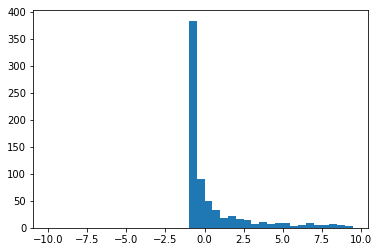

0.033333333333333333

In [61]:
percent_error = (10**y_predict - 10**y_test) / 10**y_test

plt.hist(percent_error, bins=np.arange(-10,10,.5))
plt.show()
np.mean((percent_error < .1) & (percent_error > -.1))

In [62]:
tpot.export('tpot_fit.py')

True

- Try tpot
- Look at feature importance
- What movies is this model good at predicting
 - Group by genre, group by decade etc...
- Separate categorical variables and then try PCA
- Predicting based on decade
- Visualizations around the accuracy. X is actual revenue and y is predicted with a straight line to see the difference. Look at log as well